In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import *

import gc
gc.collect()

import os

In [2]:
train = pd.read_csv('SMBC_train.csv')
test = pd.read_csv('SMBC_test.csv')
del train['Unnamed: 0'], test['Unnamed: 0']

## EDA

In [4]:
display(train.head())
print(f"Train shape: {train.shape}")

,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,PrimaryNAICS,...,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
0,VISCOFAN USA INC,40.141389,-87.581111,915 N MICHIGAN AVE,DANVILLE,IL,61832,VERMILION,17183.0,326121,...,Other,31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,37907.936721,45598.125851,52973.139946
1,"CORNWELL STATION - DOMINION TRANSMISSION, INC",38.475305,-81.278957,200 RIVER HAVEN ROAD,CLENDENIN,WV,25045-9304,KANAWHA,54039.0,486210,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,55507.543666,72387.334115,58225.196089,76376.547318,55910.066617
2,WEST UNION COMPRESSOR STATION,39.299820,-80.857170,3041 LONG RUN RD.,GREENWOOD,WV,26415,RITCHIE,54085.0,211112,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55679.543214
3,"DOUBLE ""C"" LIMITED",35.490363,-119.042957,10245 OILFIELD ROAD,BAKERSFIELD,CA,93308,KERN,6029.0,221112,...,Power Plants,NaN,NaN,NaN,NaN,54811.222708,69339.923002,63647.340038,53799.011225,61411.902782
4,LAKESHORE PLANT,41.532802,-81.636448,6800 S MARGINAL RD,CLEVELAND,OH,441031047,CUYAHOGA,39035.0,221112,...,Power Plants,29553.796627,28337.832145,30840.825454,25153.901905,81812.306362,53823.561587,77391.157768,17662.966241,43100.469774


Train shape: (4655, 21)


In [5]:
display(test.head())
print(f"Train shape: {test.shape}")

,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons
0,ROGER AOTSCHEGAROW,38.03304,-97.97317,1910 SOUTH BROADACRES ROAD,HUTCHINSON,KS,67501,RENO,20155.0,211112,NaN,"Natural Gas and Natural Gas Liquids Suppliers,...",NaN,NaN,NaN,NaN,88951.390376,65803.021457,28993.291470,32965.487915
1,EPNG STATION 6543 LORDSBURG,32.31603,-108.60680,NaN,LORDSBURG,NM,88045,HIDALGO,35023.0,486210,NaN,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,311926.001251,268668.069110
2,OWENS-BROCKWAY GLASS CONTAINER INC PLANT 19,41.25150,-78.74244,3831 ROUTE 219,BROCKPORT,PA,15823,JEFFERSON,42065.0,327213,NaN,Minerals,28275.061385,32075.140635,26445.792090,23385.161510,84908.372871,6212.899604,34732.906397,39045.247387
3,WALDORF CORP (DBA ROCKTENN),44.95966,-93.19341,2250 WABASH AVE,SAINT PAUL,MN,551141895,RAMSEY,27123.0,322130,NaN,Pulp and Paper,37330.205714,42503.897432,43906.102080,42958.306538,49004.603631,52.038452,14262.365973,20204.924986
4,SOLAR TURBINES INC KEARNY MESA,32.81872,-117.12580,4200 RUFFIN RD MZ T-2,SAN DIEGO,CA,92123,SAN DIEGO,6073.0,333611,NaN,Other,45310.722699,39897.800897,40203.428231,39437.099224,84959.769922,15351.359676,40006.544010,63935.249120


Train shape: (2508, 20)


### 結合

In [7]:
df = pd.concat([train, test])
df = df.reset_index()

### FacilityName, Latitude, Longitude, LocationAddress

In [9]:
df['FacilityName'].value_counts()

FacilityName
ARDAGH GLASS INC                        11
NEW NGC INC D/B/A NATIONAL GYPSUM CO     8
TYSON FRESH MEATS INC                    7
US GYPSUM CO                             6
GUARDIAN INDUSTRIES CORP                 6
                                        ..
BASTROP ENERGY CENTER                    1
HARRISON HUB COMPLEX                     1
LANXESS CORPORATION                      1
SALEM COUNTY - DUPONT STP/CS             1
XTO - NEW TEAGUE PLANT                   1
Name: count, Length: 6904, dtype: int64

施設名被りがある

In [11]:
# FacilityName列で重複している行を抽出
duplicate_facility_names = df[df['FacilityName'].duplicated(keep=False)]
duplicate_facility_names

,index,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,...,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
18,18,ARMSTRONG WORLD INDUSTRIES INC,45.844165,-122.817421,1645 RAILROAD AVE,SAINT HELENS,OR,970513100,COLUMBIA,41009.0,...,Other,20845.577459,14816.760637,17237.062156,17862.296925,4.488488e+04,1.397013e+04,3.321842e+04,21599.791709,4.354453e+04
25,25,KIMBERLY-CLARK CORP,33.416151,-81.896431,246 OLD JACKSON HIGHWAY,BEECH ISLAND,SC,29842,AIKEN,45003.0,...,Pulp and Paper,NaN,NaN,NaN,NaN,2.972544e+06,9.081135e+05,3.375397e+05,329206.449634,1.835038e+06
51,51,TAMINCO US INC,30.603560,-87.133050,4575 HIGHWAY 90 EAST,PACE,FL,325712043,SANTA ROSA,12113.0,...,Chemicals,29640.799571,31892.788469,134309.667674,30671.907052,1.753534e+04,1.601194e+04,8.081507e+04,40464.405262,5.446047e+04
90,90,ORANGE COUNTY LANDFILL,28.480790,-81.218750,5901 YOUNG PINE RD,ORLANDO,FL,32829,ORANGE,12095.0,...,Waste,NaN,NaN,NaN,NaN,4.273145e+02,1.722808e+04,7.666929e+04,10469.568755,2.109851e+04
97,97,SID RICHARDSON CARBON CO,35.665516,-101.435748,9455 FM 1559,BORGER,TX,79007,HUTCHINSON,48233.0,...,Chemicals,34700.871518,26063.433240,32480.757082,31938.127813,6.687415e+04,8.635470e+04,7.854037e+04,45912.039799,5.360517e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7125,2470,TYSON FARMS INC.,35.954580,-80.721080,501 SHEFFIELD RD,HARMONY,NC,28634,IREDELL,37097.0,...,Other,37465.359478,35168.336481,30514.791288,22508.134140,4.921576e+04,1.317741e+04,4.012747e+04,16094.114680,NaN
7127,2472,CARGILL INC,39.824170,-84.174720,3201 NEEDMORE RD,DAYTON,OH,45414,MONTGOMERY,39113.0,...,Other,32358.994475,22015.936394,25351.603941,19818.110706,4.215092e+05,2.098798e+06,1.570064e+06,222314.209518,NaN
7146,2491,BASF CORP,39.711610,-75.609060,205 S JAMES ST,NEWPORT,DE,19804,NEW CASTLE,10003.0,...,Chemicals,24569.225640,19337.836294,27557.985700,23819.258974,7.501727e+04,5.023836e+04,3.176099e+04,36171.513067,NaN
7159,2504,SONORA GAS PLANT,31.361795,-101.776403,NaN,RANKIN,TX,79778,UPTON,48461.0,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


施設名は違うが住所が同じ場合、会社は同じ

In [13]:
# Latitude列,Longitude列の欠損値を除き、重複している行を抽出
duplicate_Lat_Long = df[df['Latitude'].notna() & df['Latitude'] & df['Longitude'].notna() & df['Longitude'].duplicated(keep=False)]
duplicate_Lat_Long

,index,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,...,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
10,10,AREA 61 CGP FACILITY,28.623480,-97.994280,5911 COUNTY ROAD 136,PAWNEE,TX,78145,NaN,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,2.554039e+05,266172.726519,184667.963696
14,14,TRANSCO STATION 54,30.671703,-92.125385,3149 LOUISIANA HWY 10,WASHINGTON,LA,70589,SAINT LANDRY,22097.0,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,57705.081909,35212.081189,5.518348e+04,10377.349662,43380.621524
143,143,NWE/OMIMEX NGL PLANT (CUT BANK),46.013660,-112.534340,40 E. BROADWAY,BUTTE,MT,59701,SILVER BOW,30093.0,...,"Natural Gas and Natural Gas Liquids Suppliers,...",NaN,NaN,NaN,NaN,NaN,92409.668985,9.816355e+04,63147.391827,47841.336579
152,152,"Cascades Tissue Group-Oregon, a division of Ca...",45.847600,-122.803000,1300 KASTER ROAD,SAINT HELENS,OR,97051,COLUMBIA,41009.0,...,Pulp and Paper,NaN,NaN,NaN,NaN,349886.441427,319445.002574,5.808105e+05,227503.795836,484862.380347
166,166,KERN RIVER FIELD - TEXACO,35.426860,-118.992220,1546 CHINA GRAD,BAKERSFIELD,CA,93308-9700,KERN,6029.0,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,117017.384623,87876.460181,7.326970e+04,23014.664018,53029.134431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7011,2356,Freeport Power Plant No. 2,40.646314,-73.569566,289 BUFFALO AVE,FREEPORT,NY,11520,NASSAU,36059.0,...,Power Plants,NaN,NaN,NaN,NaN,96515.812631,56523.723822,9.327050e+04,71666.774048,NaN
7041,2386,KERN RIVER GAS TRANSMISSION COMPANY: MUDDY CRE...,42.023456,-110.569218,1419 WAGON WHEEL ROAD,KEMMERER,WY,83101,LINCOLN,56023.0,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,47062.725450,43263.076774,3.321427e+04,37925.180433,NaN
7092,2437,U.S. LIME COMPRESSOR,32.445575,-97.568060,FRON GLEN ROSE EAST ON US67-8.18 MILESTO INTX ...,GODLEY,TX,76044,JOHNSON,48251.0,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,60271.695360,4.276970e+04,47671.981116,NaN
7099,2444,COLUMBIA GULF TRANSMISSION CO - DELHI COMPRESS...,32.409368,-91.487253,7179 STATE HWY 17,DELHI,LA,71232,RICHLAND,22083.0,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,45453.301808,71771.257278,3.802129e+04,35655.876910,NaN


In [14]:
duplicate_Lat_Long[duplicate_Lat_Long['Latitude'] == 28.623480]

,index,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,...,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
10,10,AREA 61 CGP FACILITY,28.62348,-97.99428,5911 COUNTY ROAD 136,PAWNEE,TX,78145,NaN,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,255403.945915,266172.726519,1.846680e+05
1587,1587,AREA 11B CGP,28.62348,-97.99428,5911 COUNTY ROAD 136,PAWNEE,TX,78145,NaN,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.800755e+04
1749,1749,AREA 81 CGP FACILITY,28.62348,-97.99428,5911 COUNTY ROAD 136,PAWNEE,TX,78145,NaN,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,732288.481642,91264.557156,2.547627e+06
2110,2110,AREA 31 CGP FACILITY,28.62348,-97.99428,5911 COUNTY ROAD 136,PAWNEE,TX,78145,NaN,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,57832.569693,85811.410377,4.751409e+04


施設名の前半部分を会社名と仮定し、カラムに追加

In [16]:
# company 列を 'a' というデフォルトの値で追加
df.insert(1, 'company', 'a')

# FacilityName の各値を空白で分割し、数字が出てくる前までを company 列に設定
df['company'] = df['FacilityName'].apply(lambda x: ' '.join(re.split(r'\s+', x)[:next((i for i, part in enumerate(re.split(r'\s+', x)) if part.isdigit()), len(re.split(r'\s+', x)))]))

In [17]:
df['company'].value_counts()

company
EPNG STATION                              25
SNG STATION                               12
TGP STATION                               11
ARDAGH GLASS INC                          11
PHILLIPS                                  11
                                          ..
XTO - FARRAR PLANT                         1
CASCO BAY ENERGY INDEPENDENCE STATION.     1
POUCH TERMINAL                             1
DUBUQUE POWER PLANT                        1
XTO - NEW TEAGUE PLANT                     1
Name: count, Length: 6770, dtype: int64

In [18]:
df[df['company'] == 'EPNG STATION']

,index,company,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,...,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
1012,1012,EPNG STATION,EPNG STATION 6526 BLANCO,36.348812,-107.953184,81 COUNTY ROAD 4900,BLOOMFIELD,NM,87413,SAN JUAN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,312260.047531,4.469082e+05,3.134534e+05,3.056776e+05
1216,1216,EPNG STATION,EPNG STATION 6735 HACKBERRY,35.170800,-113.702700,"HC 12, BOX 7 NEEDLE MOUNTAIN ROAD",TOPOCK,AZ,86436,MOHAVE,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,6.099704e+04,12409.601019,3.220048e+05,4.962998e+04,2.132421e+05
1858,1858,EPNG STATION,EPNG STATION 6755 NAVAJO,35.555100,-109.727700,"15 MILES SW OF GANADO, AZ ON INDIAN ROAD 9205",GANADO,AZ,86505,APACHE,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,4.146956e+04,15284.493098,4.543149e+04,1.399087e+04,4.006773e+04
2090,2090,EPNG STATION,"EPNG STATION 1775 MOJAVE TOPOCK, AZ",34.744476,-114.369798,5499 WEST NEEDLE MOUNTAIN ROAD,TOPOCK,AZ,86436,MOHAVE,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,4.948004e+05,308361.088476,1.596038e+06,5.690380e+05,1.205523e+06
2134,2134,EPNG STATION,"EPNG STATION 6330 GUADALUPE, TX",31.773700,-104.907800,NaN,SALT FLAT,TX,79847,HUDSPETH,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,7.057002e+04,4.287677e+04,3.136514e+04
2400,2400,EPNG STATION,"EPNG STATION 6711 CASA GRANDE, AZ",32.939625,-112.065783,5495 GREEN ROAD,MARICOPA,AZ,85222,PINAL,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.853519e+05
2484,2484,EPNG STATION,EPNG STATION 6794 WILLIAMS,33.626275,-112.019819,11 MILES NE OF WILLIAMS,WILLIAMS,AZ,86046,COCONINO,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,1.341871e+05,83907.610866,2.453399e+05,6.414162e+04,9.350216e+04
2593,2593,EPNG STATION,EPNG STATION 6560 PECOS RIVER,32.414200,-104.226850,621 SOUTH MAIN,CARLSBAD,NM,88220,EDDY,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,3.534231e+04,69837.357313,3.856801e+04,3.172404e+04,1.734563e+04
2695,2695,EPNG STATION,"EPNG STATION 6715 DILKON, AZ",35.396600,-110.335300,NaN,DILKON,AZ,86047,NAVAJO,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.559389e+04
3090,3090,EPNG STATION,EPNG STATION 6786 SELIGMAN,35.226210,-111.586340,3920 EAST EL PASO DRIVE,FLAGSTAFF,AZ,86004,COCONINO,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,2.456182e+04,675.551962,1.711003e+04,3.832935e+04,3.202921e+04


In [19]:
df['LocationAddress'].value_counts()

LocationAddress
5911 COUNTY ROAD 136      8
5703 Crutchfield Drive    7
34759 LENCIONI AVE        5
100 NORTHPARK BLVD        5
UPPER COOK INLET          4
                         ..
143 EDGEWATER STREET      1
920 KERPER BOULEVARD      1
75 NICHOL AVE             1
5864 BENNETT LAWSON RD    1
230 FCR 640               1
Name: count, Length: 6796, dtype: int64

In [20]:
df['ZIP'].value_counts()

ZIP
0        94
82716    26
99734    23
93308    16
81650    12
         ..
92592     1
16657     1
38753     1
97045     1
64633     1
Name: count, Length: 5377, dtype: int64

In [21]:
df[df['ZIP'] == '0']

,index,company,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,...,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
9,9,"W&T ENERGY VI, LLC - MC","W&T ENERGY VI, LLC - MC 243 A (MATTERHORN)",NaN,NaN,"28.7422692, 88.82563305",OFFSHORE,LA,0,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,5.845734e+04,58294.616144,5.585740e+04
38,38,"W&T OFFSHORE, INC.: EC","W&T OFFSHORE, INC.: EC 321 A",NaN,NaN,NaN,OFFSHORE,LA,0,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,4.149312e+05,1.022720e+06,454250.876595,1.024385e+06
42,42,GB,GB 426 A,NaN,NaN,NaN,OFFSHORE,LA,0,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,89397.309073,4.087863e+04,5.777500e+04,18777.143040,3.273688e+04
116,116,SOUTH MARSH ISLAND,SOUTH MARSH ISLAND 236 A,NaN,NaN,NaN,OFFSHORE,LA,0,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,5.936268e+04,1.697754e+05,52107.982188,2.018978e+05
163,163,FIELDWOOD ENERGY LLC - EI,FIELDWOOD ENERGY LLC - EI 281 A (COMPLEX ID # ...,NaN,NaN,NaN,OFFSHORE,LA,0,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,4.321302e+04,3.694367e+04,11258.571846,6.793029e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6924,2269,"W&T ENERGY VI, LLC - VK","W&T ENERGY VI, LLC - VK 823 A (VIRGO)",NaN,NaN,NaN,OFFSHORE,LA,0,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,5.950098e+04,6.324234e+04,53689.330770,NaN
6945,2290,SHIP SHOAL,SHIP SHOAL 208 H (COMPLEX ID # 20328),NaN,NaN,NaN,OFFSHORE,LA,0,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6960,2305,VERMILLION,VERMILLION 371 A,NaN,NaN,NaN,OFFSHORE,LA,0,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,2.056245e+06,1.569672e+06,241540.276864,NaN
7008,2353,SHIP SHOAL,"SHIP SHOAL 114 L, B-AUX, J",NaN,NaN,NaN,OFFSHORE,LA,0,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df['City'].value_counts()

City
OFFSHORE            94
HOUSTON             32
GILLETTE            28
PASADENA            28
BAKERSFIELD         24
                    ..
OREGON CITY          1
INVERNESS            1
JAMES CREEK          1
CARRIZON SPRINGS     1
HURLOCK              1
Name: count, Length: 3381, dtype: int64

In [23]:
df['State'].value_counts()

State
TX    859
CA    469
LA    406
PA    326
IL    269
OH    256
MI    222
NY    217
IN    201
OK    200
FL    185
AL    173
GA    170
VA    156
CO    156
KY    153
AR    152
IA    151
WI    139
NC    136
MN    135
WV    134
KS    123
TN    119
MO    114
MS    113
WY    112
SC    108
NJ    106
NM     96
AZ     91
WA     89
MA     81
UT     77
NE     74
AK     70
MD     66
OR     60
ND     49
CT     47
ID     41
NV     41
MT     36
SD     36
ME     29
HI     27
PR     25
DE     19
NH     18
RI     11
VT      8
DC      5
VI      4
GU      3
Name: count, dtype: int64

### 業界

In [25]:
df.insert(df.columns.get_loc('PrimaryNAICS') + 1, 'industryCode(2)', df['PrimaryNAICS'].astype(str).str[:2])
df.insert(df.columns.get_loc('industryCode(2)') + 1, 'industryCode(3)', df['PrimaryNAICS'].astype(str).str[:3])
df.insert(df.columns.get_loc('industryCode(3)') + 1, 'industryCode(4)', df['PrimaryNAICS'].astype(str).str[:4])

In [26]:
df['PrimaryNAICS'].value_counts()

PrimaryNAICS
221112    1348
562212    1214
486210     631
211111     545
211112     286
          ... 
212113       1
327110       1
331411       1
335912       1
326130       1
Name: count, Length: 257, dtype: int64

In [27]:
df['industryCode(2)'].value_counts()

industryCode(2)
22    1505
32    1465
56    1299
21    1151
48     650
33     469
31     371
61     109
92      66
62      25
54      21
42       9
11       5
49       4
72       4
23       3
53       3
81       2
71       1
52       1
Name: count, dtype: int64

In [28]:
df['industryCode(3)'].value_counts()

industryCode(3)
221    1505
562    1295
211     831
325     649
486     640
327     349
311     320
331     265
322     234
212     200
324     172
213     120
611     109
336      82
928      55
334      52
326      36
312      32
332      31
622      24
321      22
541      21
333      19
335      15
313      13
488       8
314       6
424       6
561       4
493       4
339       4
111       4
721       4
531       3
237       3
323       3
423       3
921       3
922       3
924       2
481       2
923       2
813       2
713       1
525       1
115       1
621       1
926       1
337       1
Name: count, dtype: int64

In [29]:
df['industryCode(4)'].value_counts()

industryCode(4)
2211    1413
5622    1288
2111     831
4862     631
3251     445
        ... 
3332       1
1119       1
3351       1
3118       1
3372       1
Name: count, Length: 114, dtype: int64

In [30]:
df['IndustryType'].value_counts()

IndustryType
Petroleum and Natural Gas Systems                                                                   1502
Power Plants                                                                                        1456
Waste                                                                                               1311
Other                                                                                               1109
Minerals                                                                                             368
                                                                                                    ... 
Pulp and Paper,Suppliers of CO2                                                                        1
Natural Gas and Natural Gas Liquids Suppliers,Petroleum and Natural Gas Systems,Power Plants           1
Chemicals,Other,Petroleum and Natural Gas Systems,Waste                                                1
Chemicals,Industrial Gas Suppliers,Mineral

In [31]:
train = df[:4655]
test = df[4655:]

In [32]:
train.head()

,index,company,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,...,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
0,0,VISCOFAN USA INC,VISCOFAN USA INC,40.141389,-87.581111,915 N MICHIGAN AVE,DANVILLE,IL,61832,VERMILION,...,Other,31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,37907.936721,45598.125851,52973.139946
1,1,"CORNWELL STATION - DOMINION TRANSMISSION, INC","CORNWELL STATION - DOMINION TRANSMISSION, INC",38.475305,-81.278957,200 RIVER HAVEN ROAD,CLENDENIN,WV,25045-9304,KANAWHA,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,55507.543666,72387.334115,58225.196089,76376.547318,55910.066617
2,2,WEST UNION COMPRESSOR STATION,WEST UNION COMPRESSOR STATION,39.299820,-80.857170,3041 LONG RUN RD.,GREENWOOD,WV,26415,RITCHIE,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55679.543214
3,3,"DOUBLE ""C"" LIMITED","DOUBLE ""C"" LIMITED",35.490363,-119.042957,10245 OILFIELD ROAD,BAKERSFIELD,CA,93308,KERN,...,Power Plants,NaN,NaN,NaN,NaN,54811.222708,69339.923002,63647.340038,53799.011225,61411.902782
4,4,LAKESHORE PLANT,LAKESHORE PLANT,41.532802,-81.636448,6800 S MARGINAL RD,CLEVELAND,OH,441031047,CUYAHOGA,...,Power Plants,29553.796627,28337.832145,30840.825454,25153.901905,81812.306362,53823.561587,77391.157768,17662.966241,43100.469774


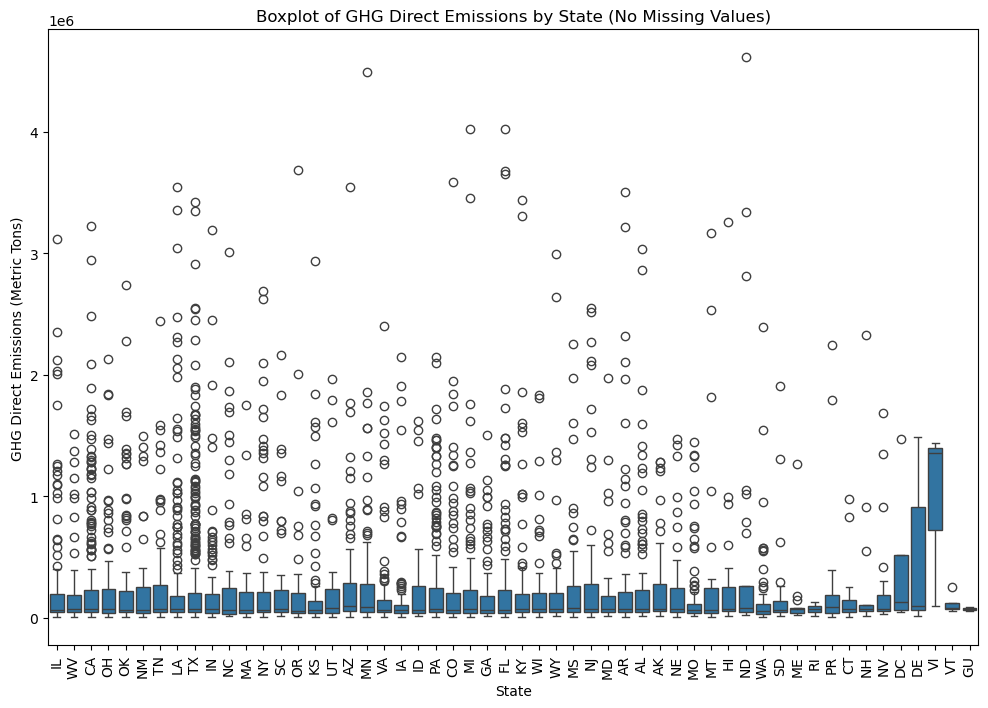

In [33]:
# プロットのサイズを指定
plt.figure(figsize=(12, 8))

# 箱ひげ図を作成
sns.boxplot(x='State', y='GHG_Direct_Emissions_14_in_metric_tons', data=train)

# ラベルとタイトルを追加
plt.xlabel('State')
plt.ylabel('GHG Direct Emissions (Metric Tons)')
plt.title('Boxplot of GHG Direct Emissions by State (No Missing Values)')
plt.xticks(rotation=90) 

# 表示
plt.show()

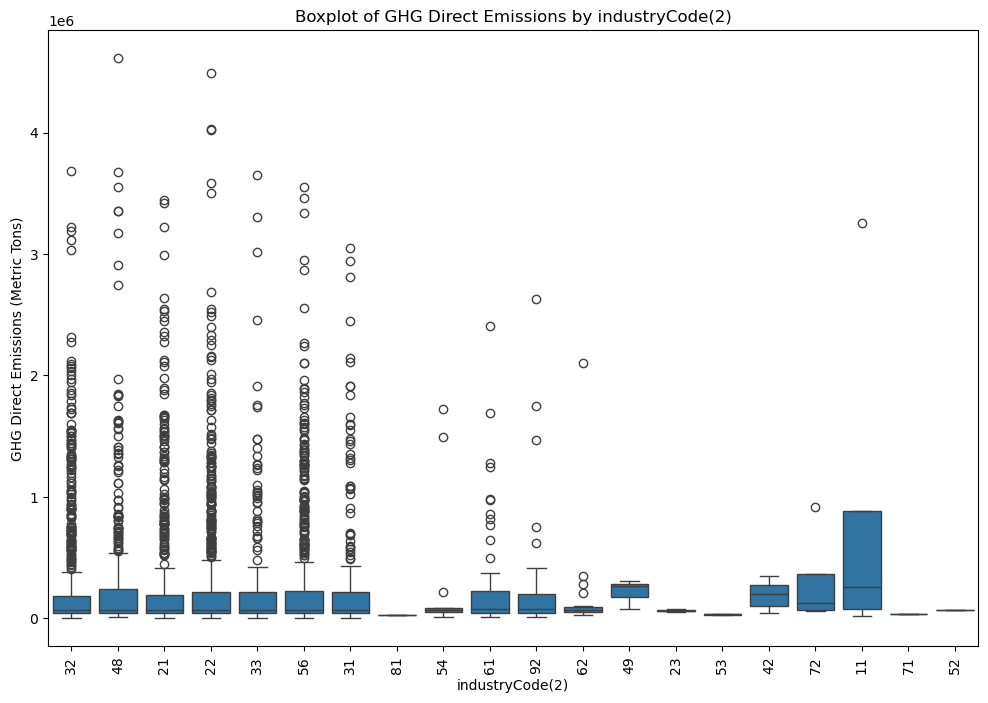

In [34]:
# プロットのサイズを指定
plt.figure(figsize=(12, 8))

# 箱ひげ図を作成
sns.boxplot(x='industryCode(2)', y='GHG_Direct_Emissions_14_in_metric_tons', data=train)

# y軸の範囲を指定
#plt.ylim(1e4, 5e5)

# ラベルとタイトルを追加
plt.xlabel('industryCode(2)')
plt.ylabel('GHG Direct Emissions (Metric Tons)')
plt.title('Boxplot of GHG Direct Emissions by industryCode(2)')
plt.xticks(rotation=90)  

# 表示
plt.show()

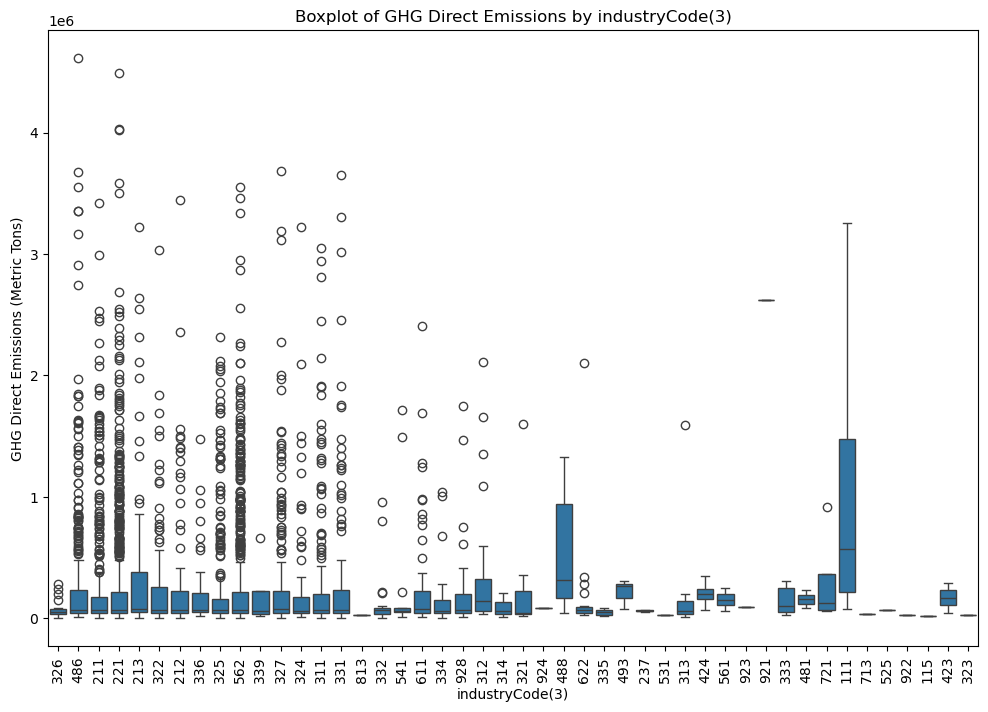

In [35]:
# プロットのサイズを指定
plt.figure(figsize=(12, 8))

# 箱ひげ図を作成
sns.boxplot(x='industryCode(3)', y='GHG_Direct_Emissions_14_in_metric_tons', data=train)

# y軸の範囲を指定
#plt.ylim(1e4, 5e5)

# ラベルとタイトルを追加
plt.xlabel('industryCode(3)')
plt.ylabel('GHG Direct Emissions (Metric Tons)')
plt.title('Boxplot of GHG Direct Emissions by industryCode(3)')
plt.xticks(rotation=90)  

# 表示
plt.show()

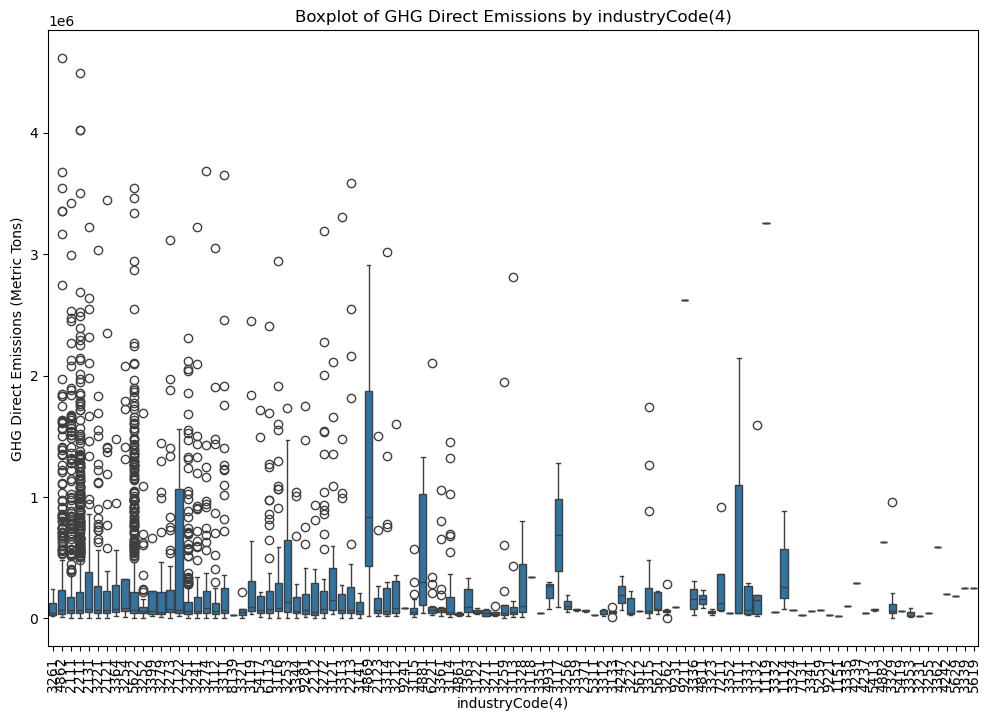

In [36]:
# プロットのサイズを指定
plt.figure(figsize=(12, 8))

# 箱ひげ図を作成
sns.boxplot(x='industryCode(4)', y='GHG_Direct_Emissions_14_in_metric_tons', data=train)

# y軸の範囲を指定
#plt.ylim(1e4, 5e5)

# ラベルとタイトルを追加
plt.xlabel('industryCode(4)')
plt.ylabel('GHG Direct Emissions (Metric Tons)')
plt.title('Boxplot of GHG Direct Emissions by industryCode(4)')
plt.xticks(rotation=90)  

# 表示
plt.show()

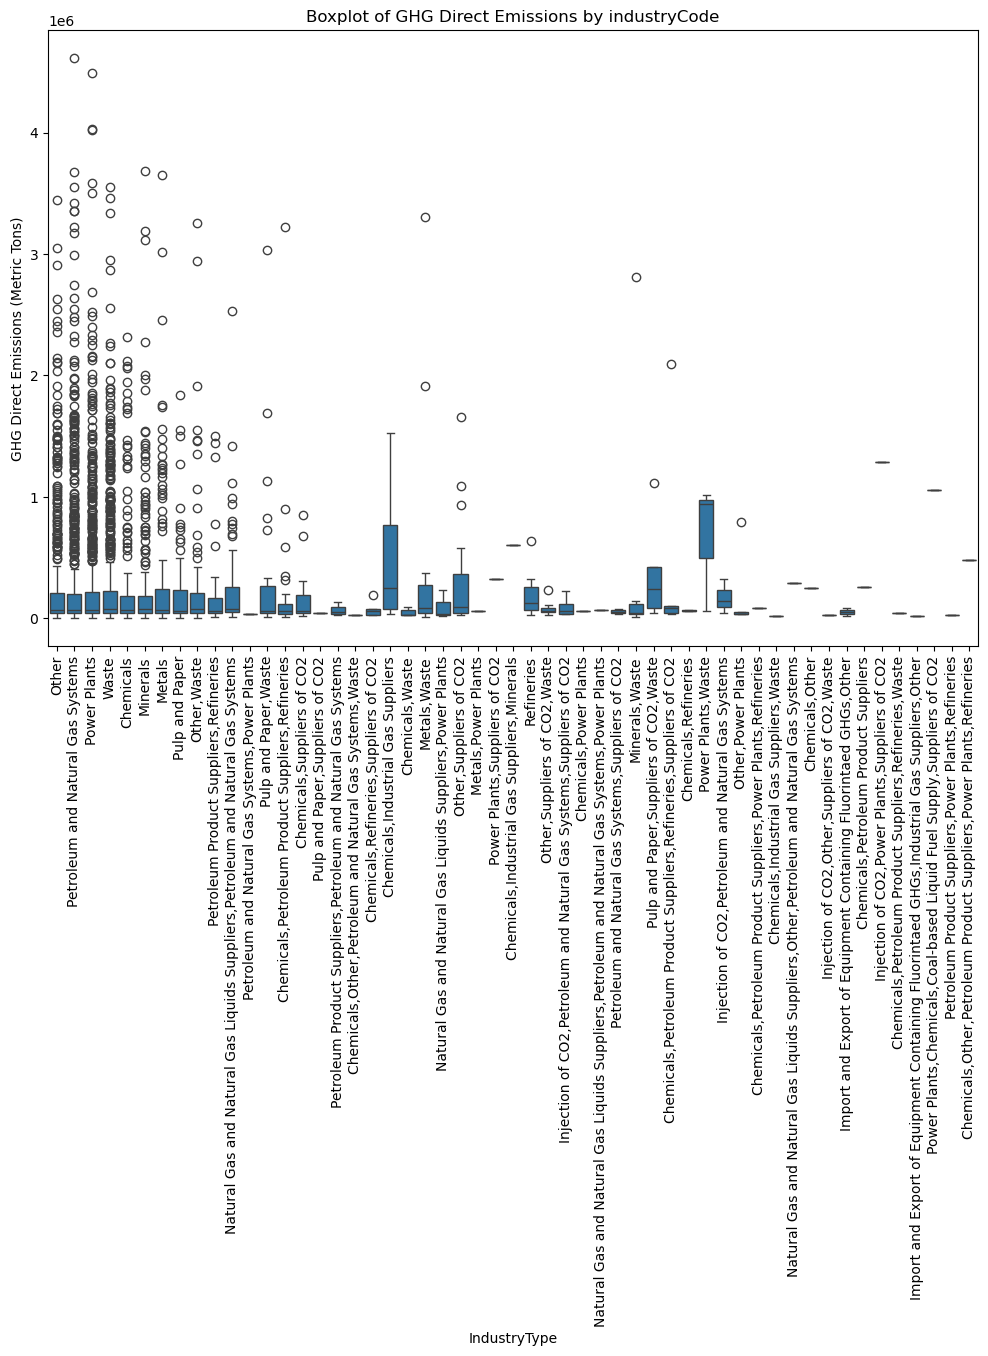

In [37]:
# プロットのサイズを指定
plt.figure(figsize=(12, 8))

# 箱ひげ図を作成
sns.boxplot(x='IndustryType', y='GHG_Direct_Emissions_14_in_metric_tons', data=train)

# ラベルとタイトルを追加
plt.xlabel('IndustryType')
plt.ylabel('GHG Direct Emissions (Metric Tons)')
plt.title('Boxplot of GHG Direct Emissions by industryCode')
plt.xticks(rotation=90)  

# 表示
plt.show()

### 相関

In [39]:
train.columns

Index(['index', 'company', 'FacilityName', 'Latitude', 'Longitude',
       'LocationAddress', 'City', 'State', 'ZIP', 'County', 'FIPScode',
       'PrimaryNAICS', 'industryCode(2)', 'industryCode(3)', 'industryCode(4)',
       'SecondPrimaryNAICS', 'IndustryType', 'TRI_Air_Emissions_10_in_lbs',
       'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons',
       'GHG_Direct_Emissions_14_in_metric_tons'],
      dtype='object')

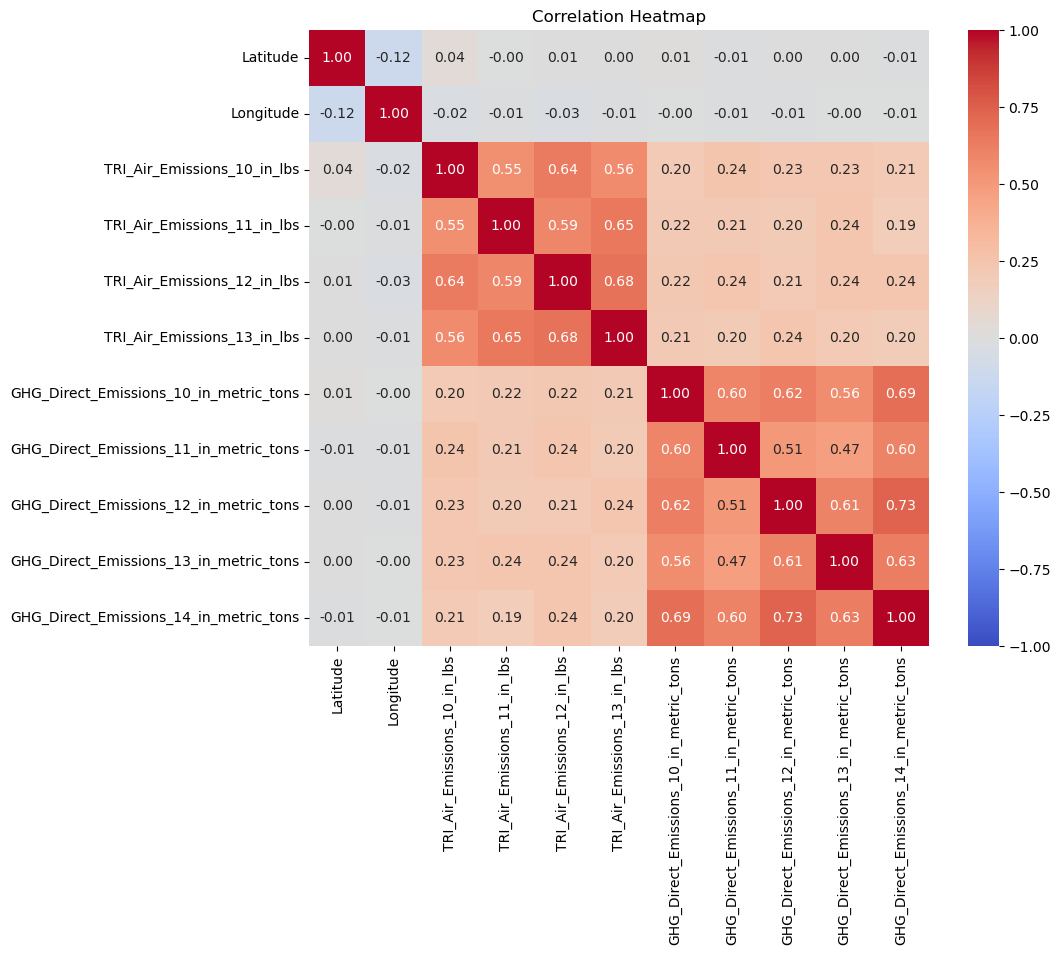

In [40]:
corr_matrix = train[['Latitude', 'Longitude',
       'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
       'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
       'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons',
       'GHG_Direct_Emissions_14_in_metric_tons']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

### 欠損値確認

In [42]:
train.isnull().sum()

index                                        0
company                                      0
FacilityName                                 0
Latitude                                   102
Longitude                                  102
LocationAddress                            179
City                                         0
State                                        0
ZIP                                          0
County                                      70
FIPScode                                    73
PrimaryNAICS                                 0
industryCode(2)                              0
industryCode(3)                              0
industryCode(4)                              0
SecondPrimaryNAICS                        4276
IndustryType                                 1
TRI_Air_Emissions_10_in_lbs               3020
TRI_Air_Emissions_11_in_lbs               3020
TRI_Air_Emissions_12_in_lbs               3020
TRI_Air_Emissions_13_in_lbs               3020
GHG_Direct_Em

### 欠損値確認

In [44]:
train.isnull().sum()

index                                        0
company                                      0
FacilityName                                 0
Latitude                                   102
Longitude                                  102
LocationAddress                            179
City                                         0
State                                        0
ZIP                                          0
County                                      70
FIPScode                                    73
PrimaryNAICS                                 0
industryCode(2)                              0
industryCode(3)                              0
industryCode(4)                              0
SecondPrimaryNAICS                        4276
IndustryType                                 1
TRI_Air_Emissions_10_in_lbs               3020
TRI_Air_Emissions_11_in_lbs               3020
TRI_Air_Emissions_12_in_lbs               3020
TRI_Air_Emissions_13_in_lbs               3020
GHG_Direct_Em

In [45]:
test.isnull().sum()

index                                        0
company                                      0
FacilityName                                 0
Latitude                                    56
Longitude                                   56
LocationAddress                            113
City                                         0
State                                        0
ZIP                                          0
County                                      45
FIPScode                                    45
PrimaryNAICS                                 0
industryCode(2)                              0
industryCode(3)                              0
industryCode(4)                              0
SecondPrimaryNAICS                        2324
IndustryType                                 0
TRI_Air_Emissions_10_in_lbs               1634
TRI_Air_Emissions_11_in_lbs               1634
TRI_Air_Emissions_12_in_lbs               1634
TRI_Air_Emissions_13_in_lbs               1634
GHG_Direct_Em

### 欠損値補完

In [47]:
df = pd.concat([train, test])
df = df.reset_index()
df = df.drop('level_0', axis=1)

Latitude, Longitude

LocationAddressにLatitude, Longitudeが書いてるやつもあるから確認

In [49]:
df['Longitude'] = -abs(df['Longitude'])

In [50]:
Lat_Long_na = df[df['Latitude'].isnull() | df['Longitude'].isnull()]
Lat_Long_na

,index,company,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,...,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
9,9,"W&T ENERGY VI, LLC - MC","W&T ENERGY VI, LLC - MC 243 A (MATTERHORN)",NaN,NaN,"28.7422692, 88.82563305",OFFSHORE,LA,0,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,5.845734e+04,58294.616144,5.585740e+04
38,38,"W&T OFFSHORE, INC.: EC","W&T OFFSHORE, INC.: EC 321 A",NaN,NaN,NaN,OFFSHORE,LA,0,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,4.149312e+05,1.022720e+06,454250.876595,1.024385e+06
42,42,GB,GB 426 A,NaN,NaN,NaN,OFFSHORE,LA,0,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,89397.309073,4.087863e+04,5.777500e+04,18777.143040,3.273688e+04
49,49,SMITH COMPRESSOR STATION,SMITH COMPRESSOR STATION,NaN,NaN,NaN,SMITH TOWNSHIP,PA,15379,WASHINGTON,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.120019e+04
116,116,SOUTH MARSH ISLAND,SOUTH MARSH ISLAND 236 A,NaN,NaN,NaN,OFFSHORE,LA,0,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,5.936268e+04,1.697754e+05,52107.982188,2.018978e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6945,2290,SHIP SHOAL,SHIP SHOAL 208 H (COMPLEX ID # 20328),NaN,NaN,NaN,OFFSHORE,LA,0,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6960,2305,VERMILLION,VERMILLION 371 A,NaN,NaN,NaN,OFFSHORE,LA,0,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,2.056245e+06,1.569672e+06,241540.276864,NaN
7008,2353,SHIP SHOAL,"SHIP SHOAL 114 L, B-AUX, J",NaN,NaN,NaN,OFFSHORE,LA,0,NaN,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7018,2363,FLYING CREEK/ BRIDGE DRAW COMPRESSOR STATION,FLYING CREEK/ BRIDGE DRAW COMPRESSOR STATION,NaN,NaN,"SECTION 29, T50N, R77W",GILLETTE,WY,82716,CAMPBELL,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,12772.414929,1.904493e+03,6.285424e+04,51223.629720,NaN


In [51]:
Lat_Long_na['LocationAddress'].value_counts()

LocationAddress
633 Callahan Avenue                                   2
7546 Gravel Lick Road                                 2
28.7422692, 88.82563305                               1
50 WARREN RD                                          1
HWY 44 17 MI W OF FREER TX                            1
24 MILES EAST OF BLANCO ON US HIGHWAY 64              1
28,8845,90.0245                                       1
32.198550, -93.483151                                 1
LAT 27 18 13.82; LONG 93 32 17.90;                    1
1253 OLD ARNOT ROAD                                   1
145 F ROAD                                            1
LAT 40.223464 LONG 104.719561                         1
X: 2,453,797.74'  Y:9,695,007.00'                     1
LAT 40.145027 LONG 104.751978                         1
171 YEARWOOD RD                                       1
SW NW S21 T37N R90W                                   1
SW1/4 OF SECTION 33, T49N, R77W                       1
15 MI E OF AZTEC                

先に数値を経度緯度に代入

In [53]:
# DMS（度分秒）形式から度（小数形式）に変換する関数
def dms_to_decimal(degrees, minutes, seconds):
    return degrees + (minutes / 60) + (seconds / 3600)

# 緯度と経度を取得して代入する処理
for idx, address in Lat_Long_na['LocationAddress'].items():
    # addressが文字列かどうかを確認
    if isinstance(address, str):
        # カンマ2つで区切られた数値形式: '28,8845,90.0245'
        if re.match(r'^-?\d+,\d+(\.\d+)?,\s*-?\d+(\.\d+)?$', address):
            parts = address.split(',')
            # 最初のカンマの位置で分割し、2番目の部分を小数点に変換
            latitude = float(parts[0] + '.' + parts[1])
            longitude = float(parts[2].strip())
            # 経度が正の場合、負の値に変換
            longitude = -abs(longitude)
            df.at[idx, 'Latitude'] = latitude
            df.at[idx, 'Longitude'] = longitude

        # DMS形式: 'LAT 27 18 13.82; LONG 93 32 17.90;'（末尾セミコロンや空白を許容）
        elif re.match(r'^LAT\s+\d+\s+\d+\s+\d+\.\d+;\s*LONG\s+\d+\s+\d+\.\d+;?\s*$', address):
            lat_match = re.search(r'LAT\s+(\d+)\s+(\d+)\s+(\d+\.\d+)', address)
            long_match = re.search(r'LONG\s+(\d+)\s+(\d+)\s+(\d+\.\d+)', address)
            
            if lat_match and long_match:
                lat_deg, lat_min, lat_sec = map(float, lat_match.groups())
                long_deg, long_min, long_sec = map(float, long_match.groups())
                
                # DMSを度に変換
                latitude = dms_to_decimal(lat_deg, lat_min, lat_sec)
                longitude = dms_to_decimal(long_deg, long_min, long_sec)
                
                # 経度が正の場合、負の値に変換
                longitude = -abs(longitude)
                
                df.at[idx, 'Latitude'] = latitude
                df.at[idx, 'Longitude'] = longitude

        # 変換不要のLAT/LONG形式: 'LAT 40.145027 LONG 104.751978'
        elif re.match(r'^LAT\s+-?\d+(\.\d+)?\s+LONG\s+-?\d+(\.\d+)?$', address):
            lat_match = re.search(r'LAT\s+(-?\d+\.\d+)', address)
            long_match = re.search(r'LONG\s+(-?\d+\.\d+)', address)
            
            if lat_match and long_match:
                latitude = float(lat_match.group(1))
                longitude = float(long_match.group(1))
                
                # 経度が正の場合、負の値に変換
                longitude = -abs(longitude)
                
                df.at[idx, 'Latitude'] = latitude
                df.at[idx, 'Longitude'] = longitude
    else:
        # addressが文字列でない場合（NaNやfloatの場合）、処理をスキップ
        continue

In [54]:
df[df['LocationAddress'] == '28,8845,90.0245']

,index,company,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,...,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
4260,4260,PUMPING PLATFORM COMPLEX GRAND ISLE,PUMPING PLATFORM COMPLEX GRAND ISLE 59,28.8845,-90.0245,"28,8845,90.0245",OFFSHORE,LA,0,NaN,...,Other,NaN,NaN,NaN,NaN,84616.215014,33718.594136,37055.604946,8804.152538,21886.950294


できないやつは今後修正

In [56]:
df[df['LocationAddress'] == 'LAT 27 18 13.82; LONG 93 32 17.90;']

,index,company,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,...,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
4477,4477,"GUNNISON SPAR, GARDEN BANKS","GUNNISON SPAR, GARDEN BANKS 668 PLATFORM ;A;",NaN,NaN,LAT 27 18 13.82; LONG 93 32 17.90;,THE WOODLANDS,TX,77380,MONTGOMERY,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,124137.568561,237846.33266,346590.503491,55358.854937,181498.682656


住所から経度緯度を算出

その他補完

In [59]:
# 各パターンごとに 'Latitude' の平均を計算
Latitude_medians = df.groupby(['City', 'State', 'County'])['Latitude'].mean().reset_index()


# 'Latitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['Latitude']):
        matching_row = Latitude_medians[
            (Latitude_medians['City'] == row['City']) &
            (Latitude_medians['State'] == row['State']) &
            (Latitude_medians['County'] == row['County'])
        ]
        if not matching_row.empty:
            return matching_row['Latitude'].values[0]
    return row['Latitude']

df['Latitude'] = df.apply(fill_age, axis=1)

In [60]:
# 各パターンごとに 'Latitude' の平均を計算
Latitude_medians = df.groupby(['City', 'State'])['Latitude'].mean().reset_index()


# 'Latitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['Latitude']):
        matching_row = Latitude_medians[
            (Latitude_medians['City'] == row['City']) &
            (Latitude_medians['State'] == row['State']) 
        ]
        if not matching_row.empty:
            return matching_row['Latitude'].values[0]
    return row['Latitude']

df['Latitude'] = df.apply(fill_age, axis=1)

In [61]:
# 各パターンごとに 'Latitude' の平均を計算
Latitude_medians = df.groupby(['State'])['Latitude'].mean().reset_index()


# 'Latitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['Latitude']):
        matching_row = Latitude_medians[
            (Latitude_medians['State'] == row['State']) 
        ]
        if not matching_row.empty:
            return matching_row['Latitude'].values[0]
    return row['Latitude']

df['Latitude'] = df.apply(fill_age, axis=1)

In [62]:
# 各パターンごとに 'Latitude' の平均を計算
Longitude_medians = df.groupby(['City', 'State', 'County'])['Longitude'].mean().reset_index()


# 'Longitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['Longitude']):
        matching_row = Longitude_medians[
            (Longitude_medians['City'] == row['City']) &
            (Longitude_medians['State'] == row['State']) &
            (Longitude_medians['County'] == row['County'])
        ]
        if not matching_row.empty:
            return matching_row['Longitude'].values[0]
    return row['Longitude']

df['Longitude'] = df.apply(fill_age, axis=1)

In [63]:
# 各パターンごとに 'Latitude' の平均を計算
Longitude_medians = df.groupby(['City', 'State'])['Longitude'].mean().reset_index()


# 'Longitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['Longitude']):
        matching_row = Longitude_medians[
            (Longitude_medians['City'] == row['City']) &
            (Longitude_medians['State'] == row['State'])
        ]
        if not matching_row.empty:
            return matching_row['Longitude'].values[0]
    return row['Longitude']

df['Longitude'] = df.apply(fill_age, axis=1)

In [64]:
# 各パターンごとに 'Latitude' の平均を計算
Longitude_medians = df.groupby(['State'])['Longitude'].mean().reset_index()


# 'Longitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['Longitude']):
        matching_row = Longitude_medians[
            (Longitude_medians['State'] == row['State'])
        ]
        if not matching_row.empty:
            return matching_row['Longitude'].values[0]
    return row['Longitude']

df['Longitude'] = df.apply(fill_age, axis=1)

In [65]:
df[df['City'] == 'THE WOODLANDS']

,index,company,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,...,IndustryType,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
2999,2999,"BOOMVANG SPAR, EAST BREAKS","BOOMVANG SPAR, EAST BREAKS 643 PLATFORM",31.206336,-97.66114,27 21' 12.838,THE WOODLANDS,TX,77380,MONTGOMERY,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,2.708728e+06,1.586777e+06,4.755322e+06,3.817336e+06,3.422654e+06
4477,4477,"GUNNISON SPAR, GARDEN BANKS","GUNNISON SPAR, GARDEN BANKS 668 PLATFORM ;A;",31.206336,-97.66114,LAT 27 18 13.82; LONG 93 32 17.90;,THE WOODLANDS,TX,77380,MONTGOMERY,...,Petroleum and Natural Gas Systems,NaN,NaN,NaN,NaN,1.241376e+05,2.378463e+05,3.465905e+05,5.535885e+04,1.814987e+05


In [66]:
df.describe()

,index,Latitude,Longitude,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
count,7163.000000,7163.000000,7163.000000,7045.000000,7163.000000,563.000000,2.509000e+03,2509.000000,2509.000000,2.509000e+03,6.083000e+03,6.581000e+03,6.766000e+03,6.942000e+03,4.655000e+03
mean,1951.132626,37.439729,-93.042740,29877.710575,354562.920006,319948.595027,6.286511e+04,42849.089391,52446.298883,5.426281e+04,2.513853e+05,1.608356e+05,3.147359e+05,1.854609e+05,2.525133e+05
std,1272.584941,5.815663,14.713606,16456.246045,146081.601694,40918.300464,1.412944e+05,54226.348071,94899.878505,1.096442e+05,5.229696e+05,2.681179e+05,7.413648e+05,4.118466e+05,4.854669e+05
min,0.000000,13.394900,-166.553496,1001.000000,111419.000000,115114.000000,2.279515e+03,34.450512,2076.649083,1.221438e+03,1.089413e+02,8.167190e-01,2.009966e+02,2.689283e+01,5.598067e+02
25%,895.000000,33.197509,-98.225774,17135.000000,221112.000000,322121.000000,2.508200e+04,25345.077827,22895.946746,2.256249e+04,5.065835e+04,3.650717e+04,4.748507e+04,3.534329e+04,4.174869e+04
50%,1790.000000,37.806440,-90.668333,29121.000000,325180.000000,325199.000000,3.184806e+04,31526.552891,29537.745867,2.879691e+04,7.408076e+04,6.027170e+04,7.151286e+04,5.716081e+04,6.789793e+04
75%,2863.500000,41.183307,-82.552909,45079.000000,486210.000000,331111.000000,3.980171e+04,38146.021096,36500.651026,3.617482e+04,1.761505e+05,1.324353e+05,2.245182e+05,1.170980e+05,2.109168e+05
max,4654.000000,71.292071,-64.714865,78030.000000,928110.000000,562910.000000,1.374503e+06,481505.852810,898432.732339,1.010902e+06,3.927869e+06,2.698567e+06,6.837260e+06,4.330236e+06,4.614103e+06


LocationAddress, County, FIPScode, SecondPrimaryNAICSはいったんスルー

In [68]:
df.columns

Index(['index', 'company', 'FacilityName', 'Latitude', 'Longitude',
       'LocationAddress', 'City', 'State', 'ZIP', 'County', 'FIPScode',
       'PrimaryNAICS', 'industryCode(2)', 'industryCode(3)', 'industryCode(4)',
       'SecondPrimaryNAICS', 'IndustryType', 'TRI_Air_Emissions_10_in_lbs',
       'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons',
       'GHG_Direct_Emissions_14_in_metric_tons'],
      dtype='object')

TRI_Air_Emissions_10_in_lbs

In [70]:
# 各パターンごとに 'TRI_Air_Emissions_10_in_lbs' の中央値を計算
TRI_Air_Emissions_10_in_lbs_medians = df.groupby(['industryCode(4)'])['TRI_Air_Emissions_10_in_lbs'].median().reset_index()

# 'Latitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['TRI_Air_Emissions_10_in_lbs']):
        matching_row = TRI_Air_Emissions_10_in_lbs_medians[
            (TRI_Air_Emissions_10_in_lbs_medians['industryCode(4)'] == row['industryCode(4)']) 
        ]
        if not matching_row.empty:
            return matching_row['TRI_Air_Emissions_10_in_lbs'].values[0]
    return row['TRI_Air_Emissions_10_in_lbs']

df['TRI_Air_Emissions_10_in_lbs'] = df.apply(fill_age, axis=1)

In [71]:
# 各パターンごとに 'TRI_Air_Emissions_10_in_lbs' の中央値を計算
TRI_Air_Emissions_10_in_lbs_medians = df.groupby(['industryCode(3)'])['TRI_Air_Emissions_10_in_lbs'].median().reset_index()

# 'Latitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['TRI_Air_Emissions_10_in_lbs']):
        matching_row = TRI_Air_Emissions_10_in_lbs_medians[
            (TRI_Air_Emissions_10_in_lbs_medians['industryCode(3)'] == row['industryCode(3)']) 
        ]
        if not matching_row.empty:
            return matching_row['TRI_Air_Emissions_10_in_lbs'].values[0]
    return row['TRI_Air_Emissions_10_in_lbs']

df['TRI_Air_Emissions_10_in_lbs'] = df.apply(fill_age, axis=1)

In [72]:
# 各パターンごとに 'TRI_Air_Emissions_10_in_lbs' の中央値を計算
TRI_Air_Emissions_10_in_lbs_medians = df.groupby(['industryCode(2)'])['TRI_Air_Emissions_10_in_lbs'].median().reset_index()

# 'Latitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['TRI_Air_Emissions_10_in_lbs']):
        matching_row = TRI_Air_Emissions_10_in_lbs_medians[
            (TRI_Air_Emissions_10_in_lbs_medians['industryCode(2)'] == row['industryCode(2)']) 
        ]
        if not matching_row.empty:
            return matching_row['TRI_Air_Emissions_10_in_lbs'].values[0]
    return row['TRI_Air_Emissions_10_in_lbs']

df['TRI_Air_Emissions_10_in_lbs'] = df.apply(fill_age, axis=1)

In [73]:
# 中央値を計算
median_value = df['TRI_Air_Emissions_10_in_lbs'].median()

# 欠損値を中央値で埋める
df['TRI_Air_Emissions_10_in_lbs'].fillna(median_value, inplace=True)

C:\Users\takay\AppData\Local\Temp\ipykernel_33816\3446957290.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TRI_Air_Emissions_10_in_lbs'].fillna(median_value, inplace=True)


TRI_Air_Emissions_11_in_lbs

In [75]:
# 各パターンごとに 'TRI_Air_Emissions_11_in_lbs' の中央値を計算
TRI_Air_Emissions_11_in_lbs_medians = df.groupby(['industryCode(4)'])['TRI_Air_Emissions_11_in_lbs'].median().reset_index()

# 'Latitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['TRI_Air_Emissions_11_in_lbs']):
        matching_row = TRI_Air_Emissions_11_in_lbs_medians[
            (TRI_Air_Emissions_11_in_lbs_medians['industryCode(4)'] == row['industryCode(4)']) 
        ]
        if not matching_row.empty:
            return matching_row['TRI_Air_Emissions_11_in_lbs'].values[0]
    return row['TRI_Air_Emissions_11_in_lbs']

df['TRI_Air_Emissions_11_in_lbs'] = df.apply(fill_age, axis=1)

In [76]:
# 各パターンごとに 'TRI_Air_Emissions_11_in_lbs' の中央値を計算
TRI_Air_Emissions_11_in_lbs_medians = df.groupby(['industryCode(3)'])['TRI_Air_Emissions_11_in_lbs'].median().reset_index()

# 'Latitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['TRI_Air_Emissions_11_in_lbs']):
        matching_row = TRI_Air_Emissions_11_in_lbs_medians[
            (TRI_Air_Emissions_11_in_lbs_medians['industryCode(3)'] == row['industryCode(3)']) 
        ]
        if not matching_row.empty:
            return matching_row['TRI_Air_Emissions_11_in_lbs'].values[0]
    return row['TRI_Air_Emissions_11_in_lbs']

df['TRI_Air_Emissions_11_in_lbs'] = df.apply(fill_age, axis=1)

In [77]:
# 各パターンごとに 'TRI_Air_Emissions_11_in_lbs' の中央値を計算
TRI_Air_Emissions_11_in_lbs_medians = df.groupby(['industryCode(2)'])['TRI_Air_Emissions_11_in_lbs'].median().reset_index()

# 'Latitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['TRI_Air_Emissions_11_in_lbs']):
        matching_row = TRI_Air_Emissions_11_in_lbs_medians[
            (TRI_Air_Emissions_11_in_lbs_medians['industryCode(2)'] == row['industryCode(2)']) 
        ]
        if not matching_row.empty:
            return matching_row['TRI_Air_Emissions_11_in_lbs'].values[0]
    return row['TRI_Air_Emissions_11_in_lbs']

df['TRI_Air_Emissions_11_in_lbs'] = df.apply(fill_age, axis=1)

In [78]:
# 中央値を計算
median_value = df['TRI_Air_Emissions_11_in_lbs'].median()

# 欠損値を中央値で埋める
df['TRI_Air_Emissions_11_in_lbs'].fillna(median_value, inplace=True)

C:\Users\takay\AppData\Local\Temp\ipykernel_33816\1174661967.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TRI_Air_Emissions_11_in_lbs'].fillna(median_value, inplace=True)


TRI_Air_Emissions_12_in_lbs

In [80]:
# 各パターンごとに 'TRI_Air_Emissions_12_in_lbs' の中央値を計算
TRI_Air_Emissions_12_in_lbs_medians = df.groupby(['industryCode(4)'])['TRI_Air_Emissions_12_in_lbs'].median().reset_index()

# 'Latitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['TRI_Air_Emissions_12_in_lbs']):
        matching_row = TRI_Air_Emissions_12_in_lbs_medians[
            (TRI_Air_Emissions_12_in_lbs_medians['industryCode(4)'] == row['industryCode(4)']) 
        ]
        if not matching_row.empty:
            return matching_row['TRI_Air_Emissions_12_in_lbs'].values[0]
    return row['TRI_Air_Emissions_12_in_lbs']

df['TRI_Air_Emissions_12_in_lbs'] = df.apply(fill_age, axis=1)

In [81]:
# 各パターンごとに 'TRI_Air_Emissions_12_in_lbs' の中央値を計算
TRI_Air_Emissions_12_in_lbs_medians = df.groupby(['industryCode(3)'])['TRI_Air_Emissions_12_in_lbs'].median().reset_index()

# 'Latitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['TRI_Air_Emissions_12_in_lbs']):
        matching_row = TRI_Air_Emissions_12_in_lbs_medians[
            (TRI_Air_Emissions_12_in_lbs_medians['industryCode(3)'] == row['industryCode(3)']) 
        ]
        if not matching_row.empty:
            return matching_row['TRI_Air_Emissions_12_in_lbs'].values[0]
    return row['TRI_Air_Emissions_12_in_lbs']

df['TRI_Air_Emissions_12_in_lbs'] = df.apply(fill_age, axis=1)

In [82]:
# 各パターンごとに 'TRI_Air_Emissions_12_in_lbs' の中央値を計算
TRI_Air_Emissions_12_in_lbs_medians = df.groupby(['industryCode(2)'])['TRI_Air_Emissions_12_in_lbs'].median().reset_index()

# 'Latitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['TRI_Air_Emissions_12_in_lbs']):
        matching_row = TRI_Air_Emissions_12_in_lbs_medians[
            (TRI_Air_Emissions_12_in_lbs_medians['industryCode(2)'] == row['industryCode(2)']) 
        ]
        if not matching_row.empty:
            return matching_row['TRI_Air_Emissions_12_in_lbs'].values[0]
    return row['TRI_Air_Emissions_12_in_lbs']

df['TRI_Air_Emissions_12_in_lbs'] = df.apply(fill_age, axis=1)

In [83]:
# 中央値を計算
median_value = df['TRI_Air_Emissions_12_in_lbs'].median()

# 欠損値を中央値で埋める
df['TRI_Air_Emissions_12_in_lbs'].fillna(median_value, inplace=True)

C:\Users\takay\AppData\Local\Temp\ipykernel_33816\2994361832.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TRI_Air_Emissions_12_in_lbs'].fillna(median_value, inplace=True)


TRI_Air_Emissions_13_in_lbs

In [85]:
# 各パターンごとに 'TRI_Air_Emissions_13_in_lbs' の中央値を計算
TRI_Air_Emissions_13_in_lbs_medians = df.groupby(['industryCode(4)'])['TRI_Air_Emissions_13_in_lbs'].median().reset_index()

# 'Latitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['TRI_Air_Emissions_13_in_lbs']):
        matching_row = TRI_Air_Emissions_13_in_lbs_medians[
            (TRI_Air_Emissions_13_in_lbs_medians['industryCode(4)'] == row['industryCode(4)']) 
        ]
        if not matching_row.empty:
            return matching_row['TRI_Air_Emissions_13_in_lbs'].values[0]
    return row['TRI_Air_Emissions_13_in_lbs']

df['TRI_Air_Emissions_13_in_lbs'] = df.apply(fill_age, axis=1)

In [86]:
# 各パターンごとに 'TRI_Air_Emissions_13_in_lbs' の中央値を計算
TRI_Air_Emissions_13_in_lbs_medians = df.groupby(['industryCode(3)'])['TRI_Air_Emissions_13_in_lbs'].median().reset_index()

# 'Latitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['TRI_Air_Emissions_13_in_lbs']):
        matching_row = TRI_Air_Emissions_13_in_lbs_medians[
            (TRI_Air_Emissions_13_in_lbs_medians['industryCode(3)'] == row['industryCode(3)']) 
        ]
        if not matching_row.empty:
            return matching_row['TRI_Air_Emissions_13_in_lbs'].values[0]
    return row['TRI_Air_Emissions_13_in_lbs']

df['TRI_Air_Emissions_13_in_lbs'] = df.apply(fill_age, axis=1)

In [87]:
# 各パターンごとに 'TRI_Air_Emissions_13_in_lbs' の中央値を計算
TRI_Air_Emissions_13_in_lbs_medians = df.groupby(['industryCode(2)'])['TRI_Air_Emissions_13_in_lbs'].median().reset_index()

# 'Latitude' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['TRI_Air_Emissions_13_in_lbs']):
        matching_row = TRI_Air_Emissions_13_in_lbs_medians[
            (TRI_Air_Emissions_13_in_lbs_medians['industryCode(2)'] == row['industryCode(2)']) 
        ]
        if not matching_row.empty:
            return matching_row['TRI_Air_Emissions_13_in_lbs'].values[0]
    return row['TRI_Air_Emissions_13_in_lbs']

df['TRI_Air_Emissions_13_in_lbs'] = df.apply(fill_age, axis=1)

In [88]:
# 中央値を計算
median_value = df['TRI_Air_Emissions_13_in_lbs'].median()

# 欠損値を中央値で埋める
df['TRI_Air_Emissions_13_in_lbs'].fillna(median_value, inplace=True)

C:\Users\takay\AppData\Local\Temp\ipykernel_33816\2027161842.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TRI_Air_Emissions_13_in_lbs'].fillna(median_value, inplace=True)


GHG_Direct_Emissions_10_in_metric_tons

In [90]:
# 各パターンごとに 'GHG_Direct_Emissions_10_in_metric_tons' の中央値を計算
GHG_Direct_Emissions_10_in_metric_tons_medians = df.groupby(['industryCode(4)'])['GHG_Direct_Emissions_10_in_metric_tons'].median().reset_index()

# 'GHG_Direct_Emissions_10_in_metric_tons' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['GHG_Direct_Emissions_10_in_metric_tons']):
        matching_row = GHG_Direct_Emissions_10_in_metric_tons_medians[
            (GHG_Direct_Emissions_10_in_metric_tons_medians['industryCode(4)'] == row['industryCode(4)']) 
        ]
        if not matching_row.empty:
            return matching_row['GHG_Direct_Emissions_10_in_metric_tons'].values[0]
    return row['GHG_Direct_Emissions_10_in_metric_tons']

df['GHG_Direct_Emissions_10_in_metric_tons'] = df.apply(fill_age, axis=1)

In [91]:
# 各パターンごとに 'GHG_Direct_Emissions_10_in_metric_tons' の中央値を計算
GHG_Direct_Emissions_10_in_metric_tons_medians = df.groupby(['industryCode(3)'])['GHG_Direct_Emissions_10_in_metric_tons'].median().reset_index()

# 'GHG_Direct_Emissions_10_in_metric_tons' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['GHG_Direct_Emissions_10_in_metric_tons']):
        matching_row = GHG_Direct_Emissions_10_in_metric_tons_medians[
            (GHG_Direct_Emissions_10_in_metric_tons_medians['industryCode(3)'] == row['industryCode(3)']) 
        ]
        if not matching_row.empty:
            return matching_row['GHG_Direct_Emissions_10_in_metric_tons'].values[0]
    return row['GHG_Direct_Emissions_10_in_metric_tons']

df['GHG_Direct_Emissions_10_in_metric_tons'] = df.apply(fill_age, axis=1)

In [92]:
# 各パターンごとに 'GHG_Direct_Emissions_10_in_metric_tons' の中央値を計算
GHG_Direct_Emissions_10_in_metric_tons_medians = df.groupby(['industryCode(2)'])['GHG_Direct_Emissions_10_in_metric_tons'].median().reset_index()

# 'GHG_Direct_Emissions_10_in_metric_tons' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['GHG_Direct_Emissions_10_in_metric_tons']):
        matching_row = GHG_Direct_Emissions_10_in_metric_tons_medians[
            (GHG_Direct_Emissions_10_in_metric_tons_medians['industryCode(2)'] == row['industryCode(2)']) 
        ]
        if not matching_row.empty:
            return matching_row['GHG_Direct_Emissions_10_in_metric_tons'].values[0]
    return row['GHG_Direct_Emissions_10_in_metric_tons']

df['GHG_Direct_Emissions_10_in_metric_tons'] = df.apply(fill_age, axis=1)

In [93]:
# 中央値を計算
median_value = df['GHG_Direct_Emissions_10_in_metric_tons'].median()

# 欠損値を中央値で埋める
df['GHG_Direct_Emissions_10_in_metric_tons'].fillna(median_value, inplace=True)

C:\Users\takay\AppData\Local\Temp\ipykernel_33816\4002140363.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['GHG_Direct_Emissions_10_in_metric_tons'].fillna(median_value, inplace=True)


GHG_Direct_Emissions_11_in_metric_tons

In [95]:
# 各パターンごとに 'GHG_Direct_Emissions_11_in_metric_tons' の中央値を計算
GHG_Direct_Emissions_11_in_metric_tons_medians = df.groupby(['industryCode(4)'])['GHG_Direct_Emissions_11_in_metric_tons'].median().reset_index()

# 'GHG_Direct_Emissions_11_in_metric_tons' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['GHG_Direct_Emissions_11_in_metric_tons']):
        matching_row = GHG_Direct_Emissions_11_in_metric_tons_medians[
            (GHG_Direct_Emissions_11_in_metric_tons_medians['industryCode(4)'] == row['industryCode(4)']) 
        ]
        if not matching_row.empty:
            return matching_row['GHG_Direct_Emissions_11_in_metric_tons'].values[0]
    return row['GHG_Direct_Emissions_11_in_metric_tons']

df['GHG_Direct_Emissions_11_in_metric_tons'] = df.apply(fill_age, axis=1)

In [96]:
# 各パターンごとに 'GHG_Direct_Emissions_11_in_metric_tons' の中央値を計算
GHG_Direct_Emissions_11_in_metric_tons_medians = df.groupby(['industryCode(3)'])['GHG_Direct_Emissions_11_in_metric_tons'].median().reset_index()

# 'GHG_Direct_Emissions_11_in_metric_tons' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['GHG_Direct_Emissions_11_in_metric_tons']):
        matching_row = GHG_Direct_Emissions_11_in_metric_tons_medians[
            (GHG_Direct_Emissions_11_in_metric_tons_medians['industryCode(3)'] == row['industryCode(3)']) 
        ]
        if not matching_row.empty:
            return matching_row['GHG_Direct_Emissions_11_in_metric_tons'].values[0]
    return row['GHG_Direct_Emissions_11_in_metric_tons']

df['GHG_Direct_Emissions_11_in_metric_tons'] = df.apply(fill_age, axis=1)

In [97]:
# 各パターンごとに 'GHG_Direct_Emissions_11_in_metric_tons' の中央値を計算
GHG_Direct_Emissions_11_in_metric_tons_medians = df.groupby(['industryCode(2)'])['GHG_Direct_Emissions_11_in_metric_tons'].median().reset_index()

# 'GHG_Direct_Emissions_11_in_metric_tons' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['GHG_Direct_Emissions_11_in_metric_tons']):
        matching_row = GHG_Direct_Emissions_11_in_metric_tons_medians[
            (GHG_Direct_Emissions_11_in_metric_tons_medians['industryCode(2)'] == row['industryCode(2)']) 
        ]
        if not matching_row.empty:
            return matching_row['GHG_Direct_Emissions_11_in_metric_tons'].values[0]
    return row['GHG_Direct_Emissions_11_in_metric_tons']

df['GHG_Direct_Emissions_11_in_metric_tons'] = df.apply(fill_age, axis=1)

In [98]:
# 中央値を計算
median_value = df['GHG_Direct_Emissions_11_in_metric_tons'].median()

# 欠損値を中央値で埋める
df['GHG_Direct_Emissions_11_in_metric_tons'].fillna(median_value, inplace=True)

C:\Users\takay\AppData\Local\Temp\ipykernel_33816\606435944.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['GHG_Direct_Emissions_11_in_metric_tons'].fillna(median_value, inplace=True)


GHG_Direct_Emissions_12_in_metric_tons

In [100]:
# 各パターンごとに 'GHG_Direct_Emissions_12_in_metric_tons' の中央値を計算
GHG_Direct_Emissions_12_in_metric_tons_medians = df.groupby(['industryCode(4)'])['GHG_Direct_Emissions_12_in_metric_tons'].median().reset_index()

# 'GHG_Direct_Emissions_12_in_metric_tons' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['GHG_Direct_Emissions_12_in_metric_tons']):
        matching_row = GHG_Direct_Emissions_12_in_metric_tons_medians[
            (GHG_Direct_Emissions_12_in_metric_tons_medians['industryCode(4)'] == row['industryCode(4)']) 
        ]
        if not matching_row.empty:
            return matching_row['GHG_Direct_Emissions_12_in_metric_tons'].values[0]
    return row['GHG_Direct_Emissions_12_in_metric_tons']

df['GHG_Direct_Emissions_12_in_metric_tons'] = df.apply(fill_age, axis=1)

In [101]:
# 各パターンごとに 'GHG_Direct_Emissions_12_in_metric_tons' の中央値を計算
GHG_Direct_Emissions_12_in_metric_tons_medians = df.groupby(['industryCode(3)'])['GHG_Direct_Emissions_12_in_metric_tons'].median().reset_index()

# 'GHG_Direct_Emissions_12_in_metric_tons' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['GHG_Direct_Emissions_12_in_metric_tons']):
        matching_row = GHG_Direct_Emissions_12_in_metric_tons_medians[
            (GHG_Direct_Emissions_12_in_metric_tons_medians['industryCode(3)'] == row['industryCode(3)']) 
        ]
        if not matching_row.empty:
            return matching_row['GHG_Direct_Emissions_12_in_metric_tons'].values[0]
    return row['GHG_Direct_Emissions_12_in_metric_tons']

df['GHG_Direct_Emissions_12_in_metric_tons'] = df.apply(fill_age, axis=1)

In [102]:
# 各パターンごとに 'GHG_Direct_Emissions_12_in_metric_tons' の中央値を計算
GHG_Direct_Emissions_12_in_metric_tons_medians = df.groupby(['industryCode(2)'])['GHG_Direct_Emissions_12_in_metric_tons'].median().reset_index()

# 'GHG_Direct_Emissions_12_in_metric_tons' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['GHG_Direct_Emissions_12_in_metric_tons']):
        matching_row = GHG_Direct_Emissions_12_in_metric_tons_medians[
            (GHG_Direct_Emissions_12_in_metric_tons_medians['industryCode(2)'] == row['industryCode(2)']) 
        ]
        if not matching_row.empty:
            return matching_row['GHG_Direct_Emissions_12_in_metric_tons'].values[0]
    return row['GHG_Direct_Emissions_12_in_metric_tons']

df['GHG_Direct_Emissions_12_in_metric_tons'] = df.apply(fill_age, axis=1)

In [103]:
# 中央値を計算
median_value = df['GHG_Direct_Emissions_12_in_metric_tons'].median()

# 欠損値を中央値で埋める
df['GHG_Direct_Emissions_12_in_metric_tons'].fillna(median_value, inplace=True)

C:\Users\takay\AppData\Local\Temp\ipykernel_33816\3923226108.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['GHG_Direct_Emissions_12_in_metric_tons'].fillna(median_value, inplace=True)


GHG_Direct_Emissions_13_in_metric_tons

In [105]:
# 各パターンごとに 'GHG_Direct_Emissions_13_in_metric_tons' の中央値を計算
GHG_Direct_Emissions_13_in_metric_tons_medians = df.groupby(['industryCode(4)'])['GHG_Direct_Emissions_13_in_metric_tons'].median().reset_index()

# 'GHG_Direct_Emissions_13_in_metric_tons' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['GHG_Direct_Emissions_13_in_metric_tons']):
        matching_row = GHG_Direct_Emissions_13_in_metric_tons_medians[
            (GHG_Direct_Emissions_13_in_metric_tons_medians['industryCode(4)'] == row['industryCode(4)']) 
        ]
        if not matching_row.empty:
            return matching_row['GHG_Direct_Emissions_13_in_metric_tons'].values[0]
    return row['GHG_Direct_Emissions_13_in_metric_tons']

df['GHG_Direct_Emissions_13_in_metric_tons'] = df.apply(fill_age, axis=1)

In [106]:
# 各パターンごとに 'GHG_Direct_Emissions_13_in_metric_tons' の中央値を計算
GHG_Direct_Emissions_13_in_metric_tons_medians = df.groupby(['industryCode(3)'])['GHG_Direct_Emissions_13_in_metric_tons'].median().reset_index()

# 'GHG_Direct_Emissions_13_in_metric_tons' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['GHG_Direct_Emissions_13_in_metric_tons']):
        matching_row = GHG_Direct_Emissions_13_in_metric_tons_medians[
            (GHG_Direct_Emissions_13_in_metric_tons_medians['industryCode(3)'] == row['industryCode(3)']) 
        ]
        if not matching_row.empty:
            return matching_row['GHG_Direct_Emissions_13_in_metric_tons'].values[0]
    return row['GHG_Direct_Emissions_13_in_metric_tons']

df['GHG_Direct_Emissions_13_in_metric_tons'] = df.apply(fill_age, axis=1)

In [107]:
# 各パターンごとに 'GHG_Direct_Emissions_13_in_metric_tons' の中央値を計算
GHG_Direct_Emissions_13_in_metric_tons_medians = df.groupby(['industryCode(2)'])['GHG_Direct_Emissions_13_in_metric_tons'].median().reset_index()

# 'GHG_Direct_Emissions_13_in_metric_tons' が NaN の場合、対応するパターンの平均値で埋める
def fill_age(row):
    if pd.isna(row['GHG_Direct_Emissions_13_in_metric_tons']):
        matching_row = GHG_Direct_Emissions_13_in_metric_tons_medians[
            (GHG_Direct_Emissions_13_in_metric_tons_medians['industryCode(2)'] == row['industryCode(2)']) 
        ]
        if not matching_row.empty:
            return matching_row['GHG_Direct_Emissions_13_in_metric_tons'].values[0]
    return row['GHG_Direct_Emissions_13_in_metric_tons']

df['GHG_Direct_Emissions_13_in_metric_tons'] = df.apply(fill_age, axis=1)

In [108]:
# 中央値を計算
median_value = df['GHG_Direct_Emissions_13_in_metric_tons'].median()

# 欠損値を中央値で埋める
df['GHG_Direct_Emissions_13_in_metric_tons'].fillna(median_value, inplace=True)

C:\Users\takay\AppData\Local\Temp\ipykernel_33816\2736107300.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['GHG_Direct_Emissions_13_in_metric_tons'].fillna(median_value, inplace=True)


In [109]:
df.describe()

,index,Latitude,Longitude,FIPScode,PrimaryNAICS,SecondPrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
count,7163.000000,7163.000000,7163.000000,7045.000000,7163.000000,563.000000,7.163000e+03,7163.000000,7163.000000,7.163000e+03,7.163000e+03,7.163000e+03,7.163000e+03,7.163000e+03,4.655000e+03
mean,1951.132626,37.439729,-93.042740,29877.710575,354562.920006,319948.595027,4.649139e+04,38562.651840,41028.157415,4.055717e+04,2.245924e+05,1.527088e+05,3.012541e+05,1.815376e+05,2.525133e+05
std,1272.584941,5.815663,14.713606,16456.246045,146081.601694,40918.300464,8.470880e+04,32842.234391,57078.775139,6.590032e+04,4.861110e+05,2.584483e+05,7.226747e+05,4.060564e+05,4.854669e+05
min,0.000000,13.394900,-166.553496,1001.000000,111419.000000,115114.000000,2.279515e+03,34.450512,2076.649083,1.221438e+03,1.089413e+02,8.167190e-01,2.009966e+02,2.689283e+01,5.598067e+02
25%,895.000000,33.197509,-98.225774,17135.000000,221112.000000,322121.000000,3.200676e+04,30516.604988,29899.485458,2.855021e+04,5.506561e+04,3.848892e+04,4.874945e+04,3.591696e+04,4.174869e+04
50%,1790.000000,37.806440,-90.668333,29121.000000,325180.000000,325199.000000,3.319656e+04,31609.054622,31661.368166,3.261657e+04,7.444919e+04,5.994593e+04,7.076779e+04,5.664699e+04,6.789793e+04
75%,2863.500000,41.183307,-82.552909,45079.000000,486210.000000,331111.000000,4.517955e+04,43800.191180,39394.012208,3.867757e+04,1.083201e+05,1.010150e+05,2.090863e+05,1.071837e+05,2.109168e+05
max,4654.000000,71.292071,-64.714865,78030.000000,928110.000000,562910.000000,1.374503e+06,481505.852810,898432.732339,1.010902e+06,3.927869e+06,2.698567e+06,6.837260e+06,4.330236e+06,4.614103e+06


### 変数作成

TRI の差分と変化率、変化率の算術平均（AM）と幾何平均（GM）を作成

In [112]:
df['TRI_Air_Emissions_1Year_Change_11'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
df['TRI_Air_Emissions_1Year_Change_12'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
df['TRI_Air_Emissions_1Year_Change_13'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']
df['TRI_Air_Emissions_2Year_Change_12'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
df['TRI_Air_Emissions_2Year_Change_13'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
df['TRI_Air_Emissions_3Year_Change_13'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']

df['TRI_Air_Emissions_1Year_Growth_Rate_11'] = (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'] + 1
df['TRI_Air_Emissions_1Year_Growth_Rate_12'] = (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'] + 1
df['TRI_Air_Emissions_1Year_Growth_Rate_13'] = (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs'] + 1
df['TRI_Air_Emissions_2Year_Growth_Rate_12'] = (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'] + 1
df['TRI_Air_Emissions_2Year_Growth_Rate_13'] = (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'] + 1
df['TRI_Air_Emissions_3Year_Growth_Rate_13'] = (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'] + 1

df['TRI_Air_Emissions_2Year_Growth_Rate_AM_12'] = (df['TRI_Air_Emissions_1Year_Growth_Rate_11'] + df['TRI_Air_Emissions_1Year_Growth_Rate_12']) / 2
df['TRI_Air_Emissions_2Year_Growth_Rate_AM_13'] = (df['TRI_Air_Emissions_1Year_Growth_Rate_12'] + df['TRI_Air_Emissions_1Year_Growth_Rate_13']) / 2
df['TRI_Air_Emissions_3Year_Growth_Rate_AM_13'] = (df['TRI_Air_Emissions_1Year_Growth_Rate_11'] + df['TRI_Air_Emissions_1Year_Growth_Rate_12'] + df['TRI_Air_Emissions_1Year_Growth_Rate_13']) / 3

df['TRI_Air_Emissions_2Year_Growth_Rate_GM_12'] = (df['TRI_Air_Emissions_1Year_Growth_Rate_11'] * df['TRI_Air_Emissions_1Year_Growth_Rate_12']) ** (1/2)
df['TRI_Air_Emissions_2Year_Growth_Rate_GM_13'] = (df['TRI_Air_Emissions_1Year_Growth_Rate_12'] * df['TRI_Air_Emissions_1Year_Growth_Rate_13']) ** (1/2)
df['TRI_Air_Emissions_3Year_Growth_Rate_GM_13'] = (df['TRI_Air_Emissions_1Year_Growth_Rate_11'] * df['TRI_Air_Emissions_1Year_Growth_Rate_12'] * df['TRI_Air_Emissions_1Year_Growth_Rate_13']) ** (1/3)

df['TRI_Air_Emissions_1Year_Growth_Rate_11'] = df['TRI_Air_Emissions_1Year_Growth_Rate_11'] -1
df['TRI_Air_Emissions_1Year_Growth_Rate_12'] = df['TRI_Air_Emissions_1Year_Growth_Rate_12'] -1
df['TRI_Air_Emissions_1Year_Growth_Rate_13'] = df['TRI_Air_Emissions_1Year_Growth_Rate_13'] -1
df['TRI_Air_Emissions_2Year_Growth_Rate_12'] = df['TRI_Air_Emissions_2Year_Growth_Rate_12'] -1
df['TRI_Air_Emissions_2Year_Growth_Rate_13'] = df['TRI_Air_Emissions_2Year_Growth_Rate_13'] -1
df['TRI_Air_Emissions_3Year_Growth_Rate_13'] = df['TRI_Air_Emissions_3Year_Growth_Rate_13'] -1

GHG の差分と変化率、変化率の算術平均（AM）と幾何平均（GM）を作成

In [114]:
df['GHG_Direct_Emissions_1Year_Change_11'] = df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']
df['GHG_Direct_Emissions_1Year_Change_12'] = df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']
df['GHG_Direct_Emissions_1Year_Change_13'] = df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']
df['GHG_Direct_Emissions_2Year_Change_12'] = df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']
df['GHG_Direct_Emissions_2Year_Change_13'] = df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']
df['GHG_Direct_Emissions_3Year_Change_13'] = df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']

df['GHG_Direct_Emissions_1Year_Growth_Rate_11'] = (df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']) / df['GHG_Direct_Emissions_10_in_metric_tons'] + 1
df['GHG_Direct_Emissions_1Year_Growth_Rate_12'] = (df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']) / df['GHG_Direct_Emissions_11_in_metric_tons'] + 1
df['GHG_Direct_Emissions_1Year_Growth_Rate_13'] = (df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']) / df['GHG_Direct_Emissions_12_in_metric_tons'] + 1
df['GHG_Direct_Emissions_2Year_Growth_Rate_12'] = (df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']) / df['GHG_Direct_Emissions_10_in_metric_tons'] + 1
df['GHG_Direct_Emissions_2Year_Growth_Rate_13'] = (df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']) / df['GHG_Direct_Emissions_11_in_metric_tons'] + 1
df['GHG_Direct_Emissions_3Year_Growth_Rate_13'] = (df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']) / df['GHG_Direct_Emissions_10_in_metric_tons'] + 1

df['GHG_Direct_Emissions_2Year_Growth_Rate_AM_12'] = (df['GHG_Direct_Emissions_1Year_Growth_Rate_11'] + df['GHG_Direct_Emissions_1Year_Growth_Rate_12']) / 2
df['GHG_Direct_Emissions_2Year_Growth_Rate_AM_13'] = (df['GHG_Direct_Emissions_1Year_Growth_Rate_12'] + df['GHG_Direct_Emissions_1Year_Growth_Rate_13']) / 2
df['GHG_Direct_Emissions_3Year_Growth_Rate_AM_13'] = (df['GHG_Direct_Emissions_1Year_Growth_Rate_11'] + df['GHG_Direct_Emissions_1Year_Growth_Rate_12'] + df['GHG_Direct_Emissions_1Year_Growth_Rate_13']) / 3

df['GHG_Direct_Emissions_2Year_Growth_Rate_GM_12'] = (df['GHG_Direct_Emissions_1Year_Growth_Rate_11'] * df['GHG_Direct_Emissions_1Year_Growth_Rate_12']) ** (1/2)
df['GHG_Direct_Emissions_2Year_Growth_Rate_GM_13'] = (df['GHG_Direct_Emissions_1Year_Growth_Rate_12'] * df['GHG_Direct_Emissions_1Year_Growth_Rate_13']) ** (1/2)
df['GHG_Direct_Emissions_3Year_Growth_Rate_GM_13'] = (df['GHG_Direct_Emissions_1Year_Growth_Rate_11'] * df['GHG_Direct_Emissions_1Year_Growth_Rate_12'] * df['GHG_Direct_Emissions_1Year_Growth_Rate_13']) ** (1/3)

df['GHG_Direct_Emissions_1Year_Growth_Rate_11'] = df['GHG_Direct_Emissions_1Year_Growth_Rate_11'] -1
df['GHG_Direct_Emissions_1Year_Growth_Rate_12'] = df['GHG_Direct_Emissions_1Year_Growth_Rate_12'] -1
df['GHG_Direct_Emissions_1Year_Growth_Rate_13'] = df['GHG_Direct_Emissions_1Year_Growth_Rate_13'] -1
df['GHG_Direct_Emissions_2Year_Growth_Rate_13'] = df['GHG_Direct_Emissions_2Year_Growth_Rate_13'] -1
df['GHG_Direct_Emissions_3Year_Growth_Rate_13'] = df['GHG_Direct_Emissions_3Year_Growth_Rate_13'] -1

In [115]:
df['TRI_to_GHG_Ratio_10'] = df['TRI_Air_Emissions_10_in_lbs'] / (df['GHG_Direct_Emissions_10_in_metric_tons'] + 1e-6)  # Avoid division by zero
df['TRI_to_GHG_Ratio_11'] = df['TRI_Air_Emissions_11_in_lbs'] / (df['GHG_Direct_Emissions_11_in_metric_tons'] + 1e-6)
df['TRI_to_GHG_Ratio_12'] = df['TRI_Air_Emissions_12_in_lbs'] / (df['GHG_Direct_Emissions_12_in_metric_tons'] + 1e-6)
df['TRI_to_GHG_Ratio_13'] = df['TRI_Air_Emissions_13_in_lbs'] / (df['GHG_Direct_Emissions_13_in_metric_tons'] + 1e-6)

In [116]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,7163.0,1951.132626,1272.584941,0.000000e+00,895.000000,1790.000000,2863.500000,4.654000e+03
Latitude,7163.0,37.439729,5.815663,1.339490e+01,33.197509,37.806440,41.183307,7.129207e+01
Longitude,7163.0,-93.042740,14.713606,-1.665535e+02,-98.225774,-90.668333,-82.552909,-6.471487e+01
FIPScode,7045.0,29877.710575,16456.246045,1.001000e+03,17135.000000,29121.000000,45079.000000,7.803000e+04
PrimaryNAICS,7163.0,354562.920006,146081.601694,1.114190e+05,221112.000000,325180.000000,486210.000000,9.281100e+05
SecondPrimaryNAICS,563.0,319948.595027,40918.300464,1.151140e+05,322121.000000,325199.000000,331111.000000,5.629100e+05
TRI_Air_Emissions_10_in_lbs,7163.0,46491.386123,84708.798839,2.279515e+03,32006.756701,33196.557266,45179.548016,1.374503e+06
TRI_Air_Emissions_11_in_lbs,7163.0,38562.651840,32842.234391,3.445051e+01,30516.604988,31609.054622,43800.191180,4.815059e+05
TRI_Air_Emissions_12_in_lbs,7163.0,41028.157415,57078.775139,2.076649e+03,29899.485458,31661.368166,39394.012208,8.984327e+05
TRI_Air_Emissions_13_in_lbs,7163.0,40557.172475,65900.317456,1.221438e+03,28550.209382,32616.566141,38677.569716,1.010902e+06


### 相関

In [118]:
train = df[:4655]
test = df[4655:]

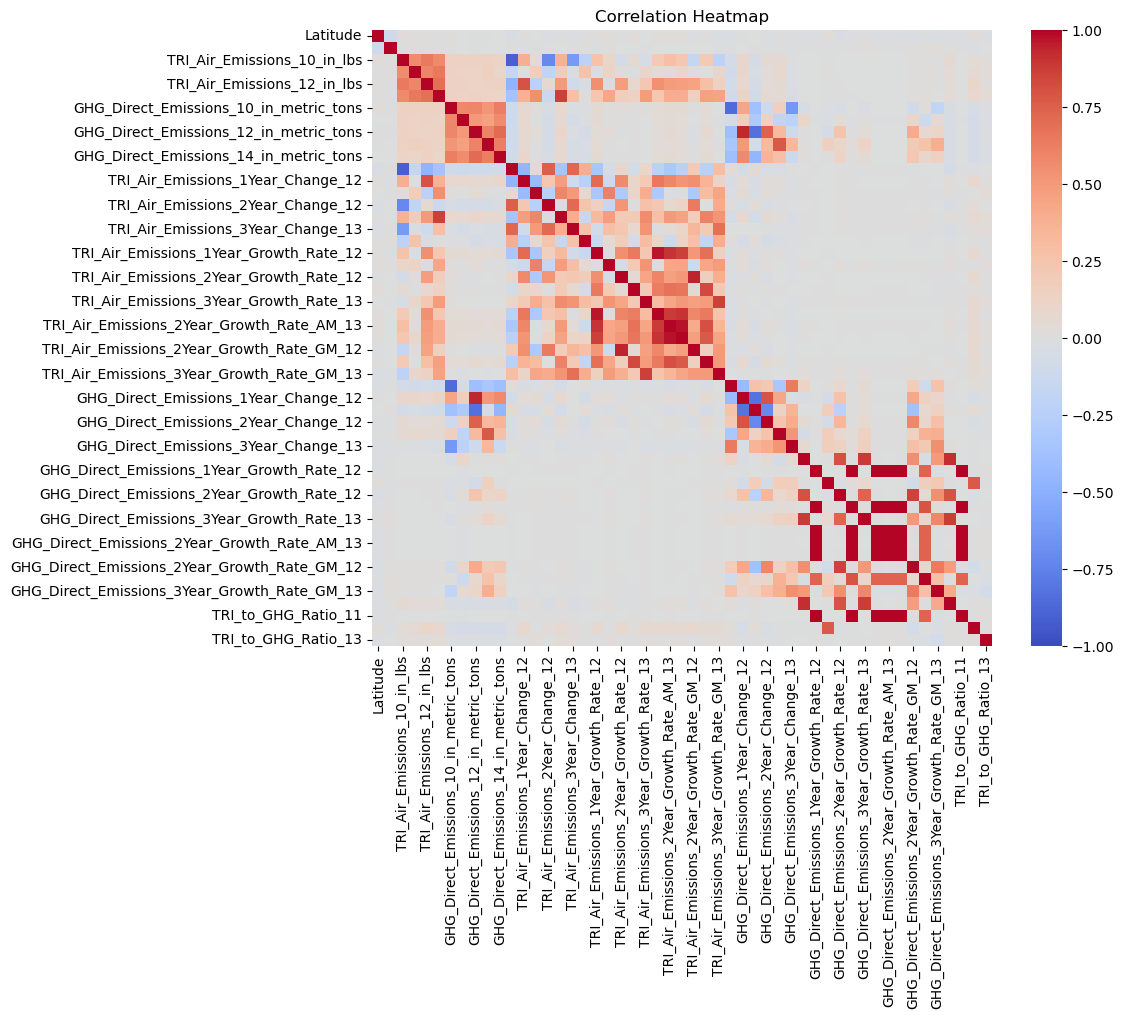

In [119]:
corr_matrix = train[['Latitude', 'Longitude', 'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'GHG_Direct_Emissions_10_in_metric_tons','GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons','GHG_Direct_Emissions_13_in_metric_tons','GHG_Direct_Emissions_14_in_metric_tons',
       'TRI_Air_Emissions_1Year_Change_11','TRI_Air_Emissions_1Year_Change_12','TRI_Air_Emissions_1Year_Change_13',
       'TRI_Air_Emissions_2Year_Change_12','TRI_Air_Emissions_2Year_Change_13','TRI_Air_Emissions_3Year_Change_13','TRI_Air_Emissions_1Year_Growth_Rate_11',
       'TRI_Air_Emissions_1Year_Growth_Rate_12','TRI_Air_Emissions_1Year_Growth_Rate_13','TRI_Air_Emissions_2Year_Growth_Rate_12','TRI_Air_Emissions_2Year_Growth_Rate_13','TRI_Air_Emissions_3Year_Growth_Rate_13',
       'TRI_Air_Emissions_2Year_Growth_Rate_AM_12','TRI_Air_Emissions_2Year_Growth_Rate_AM_13','TRI_Air_Emissions_3Year_Growth_Rate_AM_13','TRI_Air_Emissions_2Year_Growth_Rate_GM_12',
       'TRI_Air_Emissions_2Year_Growth_Rate_GM_13','TRI_Air_Emissions_3Year_Growth_Rate_GM_13','GHG_Direct_Emissions_1Year_Change_11','GHG_Direct_Emissions_1Year_Change_12',
       'GHG_Direct_Emissions_1Year_Change_13','GHG_Direct_Emissions_2Year_Change_12','GHG_Direct_Emissions_2Year_Change_13','GHG_Direct_Emissions_3Year_Change_13',
       'GHG_Direct_Emissions_1Year_Growth_Rate_11','GHG_Direct_Emissions_1Year_Growth_Rate_12','GHG_Direct_Emissions_1Year_Growth_Rate_13','GHG_Direct_Emissions_2Year_Growth_Rate_12',
       'GHG_Direct_Emissions_2Year_Growth_Rate_13','GHG_Direct_Emissions_3Year_Growth_Rate_13','GHG_Direct_Emissions_2Year_Growth_Rate_AM_12','GHG_Direct_Emissions_2Year_Growth_Rate_AM_13',
       'GHG_Direct_Emissions_3Year_Growth_Rate_AM_13','GHG_Direct_Emissions_2Year_Growth_Rate_GM_12','GHG_Direct_Emissions_2Year_Growth_Rate_GM_13','GHG_Direct_Emissions_3Year_Growth_Rate_GM_13',
                    'TRI_to_GHG_Ratio_10', 'TRI_to_GHG_Ratio_11', 'TRI_to_GHG_Ratio_12', 'TRI_to_GHG_Ratio_13']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

## モデル

In [121]:
SEED = 42
n_splits = 5

In [122]:
train.columns

Index(['index', 'company', 'FacilityName', 'Latitude', 'Longitude',
       'LocationAddress', 'City', 'State', 'ZIP', 'County', 'FIPScode',
       'PrimaryNAICS', 'industryCode(2)', 'industryCode(3)', 'industryCode(4)',
       'SecondPrimaryNAICS', 'IndustryType', 'TRI_Air_Emissions_10_in_lbs',
       'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs',
       'TRI_Air_Emissions_13_in_lbs', 'GHG_Direct_Emissions_10_in_metric_tons',
       'GHG_Direct_Emissions_11_in_metric_tons',
       'GHG_Direct_Emissions_12_in_metric_tons',
       'GHG_Direct_Emissions_13_in_metric_tons',
       'GHG_Direct_Emissions_14_in_metric_tons',
       'TRI_Air_Emissions_1Year_Change_11',
       'TRI_Air_Emissions_1Year_Change_12',
       'TRI_Air_Emissions_1Year_Change_13',
       'TRI_Air_Emissions_2Year_Change_12',
       'TRI_Air_Emissions_2Year_Change_13',
       'TRI_Air_Emissions_3Year_Change_13',
       'TRI_Air_Emissions_1Year_Growth_Rate_11',
       'TRI_Air_Emissions_1Year_Growth_Rate_12

In [123]:
target = train['GHG_Direct_Emissions_14_in_metric_tons']

df = df.drop(['index', 'company', 'FacilityName','LocationAddress', 'City', 'ZIP', 'County', 'FIPScode',
       'PrimaryNAICS', 'industryCode(3)', 'industryCode(4)',
       'SecondPrimaryNAICS', 'IndustryType',
              'GHG_Direct_Emissions_14_in_metric_tons'], axis=1)

In [124]:
df = pd.get_dummies(df, dtype=int)

In [125]:
train_df = df[:4655]
test_df = df[4655:]

In [126]:
train_df

,Latitude,Longitude,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,...,industryCode(2)_52,industryCode(2)_53,industryCode(2)_54,industryCode(2)_56,industryCode(2)_61,industryCode(2)_62,industryCode(2)_71,industryCode(2)_72,industryCode(2)_81,industryCode(2)_92
0,40.141389,-87.581111,31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,3.790794e+04,45598.125851,...,0,0,0,0,0,0,0,0,0,0
1,38.475305,-81.278957,45179.548016,45073.050587,39394.012208,32616.566141,55507.543666,72387.334115,5.822520e+04,76376.547318,...,0,0,0,0,0,0,0,0,0,0
2,39.299820,-80.857170,33196.557266,30516.604988,31661.368166,35003.310583,75390.321791,59945.929763,7.032293e+04,55706.086710,...,0,0,0,0,0,0,0,0,0,0
3,35.490363,-119.042957,32006.756701,31609.054622,29899.485458,28550.209382,54811.222708,69339.923002,6.364734e+04,53799.011225,...,0,0,0,0,0,0,0,0,0,0
4,41.532802,-81.636448,29553.796627,28337.832145,30840.825454,25153.901905,81812.306362,53823.561587,7.739116e+04,17662.966241,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4650,32.523334,-97.102556,33196.557266,30516.604988,31661.368166,35003.310583,54978.841280,56463.765036,3.522786e+06,76642.640670,...,0,0,0,0,0,0,0,0,0,0
4651,42.684900,-109.780000,33196.557266,30516.604988,31661.368166,35003.310583,208375.435367,57066.624445,4.858030e+04,26892.366779,...,0,0,0,0,0,0,0,0,0,0
4652,35.484260,-97.498570,33196.557266,31609.054622,31661.368166,32616.566141,563756.090695,598881.479485,1.665103e+06,543206.073134,...,0,0,0,0,1,0,0,0,0,0
4653,39.404310,-76.319820,46759.740152,43800.191180,43142.316105,39190.514276,67451.225733,27397.929966,3.922795e+04,46634.777768,...,0,0,0,1,0,0,0,0,0,0


In [127]:
# 特徴量名をクリーンアップする関数
def clean_feature_names(df):
    df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)  # 特殊文字をアンダースコアに置換
    return df

# データフレームをクリーンアップ
train_df = clean_feature_names(train_df)
test_df = clean_feature_names(test_df)

In [128]:
def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # LightGBMパラメータ
        lgb_params = {
            'n_estimators': 10000,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.004,
            'early_stopping_rounds': 100,
            'random_state': 42
        }
        model1 = LGBMRegressor(**lgb_params)

        # CatBoostパラメータ
        cat_params = {
            'iterations': 100000,
            'learning_rate': 0.03,
            'depth': 3,
            'eval_metric': 'RMSE',
            'colsample_bylevel': 0.8,
            'random_seed': 42,
            'bagging_temperature': 0.2,
            'early_stopping_rounds': 300
        }
        model2 = CatBoostRegressor(**cat_params)

        # モデル1のトレーニングと評価
        model1.fit(X_train, np.log1p(y_train), eval_set=[(X_valid, np.log1p(y_valid))], eval_metric="rmse")
        valid_preds1 = np.expm1(model1.predict(X_valid))
        rmsle1 = root_mean_squared_log_error(y_valid, valid_preds1)
        print(f"Fold {fold + 1} RMSLE for model1 = {rmsle1}")

        # モデル2のトレーニングと評価
        model2.fit(X_train, np.log1p(y_train), eval_set=[(X_valid, np.log1p(y_valid))], verbose=0)
        valid_preds2 = np.expm1(model2.predict(X_valid))
        rmsle2 = root_mean_squared_log_error(y_valid, valid_preds2)
        print(f"Fold {fold + 1} RMSLE for model2 = {rmsle2}")

        # RMSLEが低いモデルを選択
        if rmsle1 >= rmsle2:
            valid_preds = valid_preds2
            test_preds = model2.predict(test)
        else:
            valid_preds = valid_preds1
            test_preds = model1.predict(test)

        oof_predictions[valid_index] = valid_preds
        test_predictions += test_preds / kf.n_splits

        gc.collect()
        print('---------------\n')

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    print(f"OOF RMSLE = {RMSLE}")

    return oof_predictions, np.expm1(test_predictions)

In [130]:
# 実行
oof_predictions, test_predictions = get_models_trained(train_df, test_df, target, 10)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12856
[LightGBM] [Info] Number of data points in the train set: 4189, number of used features: 103
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Start training from score 11.430699
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[880]	valid_0's rmse: 0.716256
Fold 1 RMSLE for model1 = 0.7162555478746374
Fold 1 RMSLE for model2 = 0.6979509289155635
---------------

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM]

In [134]:
submit = pd.read_csv('SMBC_sample_submission.csv', header = None) 
submit[1] = test_predictions 
submit.to_csv('SMBC_submission.csv', header = None, index = False)

In [136]:
submit

,0,1
0,4655,4.413156e+04
1,4656,2.417064e+05
2,4657,4.033109e+04
3,4658,3.214678e+04
4,4659,4.471726e+04
...,...,...
2503,7158,7.537004e+05
2504,7159,8.980378e+04
2505,7160,1.267870e+05
2506,7161,2.895589e+05
